# Custom TTNet Implementation

## Setup

### Imports

In [21]:
import os
import glob
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import utils as vutils

### GPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(0)))

# Turns on cuDNN Autotuner
torch.backends.cudnn.benchmark = True

Device: cuda:0
GPU: NVIDIA GeForce RTX 2080 Ti


### TTNet Params

In [3]:
# Folder paths
dataset_base_path = './Dataset/images'
savePath_base = "./Trained_Models/"
savePath = savePath_base+"TTNet.pth"
outputPath = "./Results/TTNet_Results/"

# Create folders if they dont exist
if not os.path.exists(outputPath): os.makedirs(outputPath)
if not os.path.exists(savePath_base): os.makedirs(savePath_base)

# Train/Test/Validation split
train_list = [f"{x:02}" for x in range(1,25)]   # "01" to "24"
test_list = [f"{x:02}" for x in range(25,28)]   # "25" to "27"
val_list = [f"{x:02}" for x in range(28,31)]    # "28" to "30"

# Training parameters
train_batch = 8
val_batch = 8
test_batch = 8
num_workers = 16
learning_rate = 1e-4
shuffle_data = True
eps = 1e-4
sigma = 1
event_num = 5 # 0: Nothing, 1: Flying, 2: Bounce, 3: Racket Contact, 4: Net Contact

# Img resolution in dataset
data_width = 1920
data_height = 1080 
# The size the images are downscaled to when being fed to the model
TTN_width=640
TTN_height=320

seed=42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Datset

In [4]:
# TODO This entire section probably needs a rewrite
transform = transforms.Compose([
  transforms.Resize((TTN_height,TTN_width)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def default_loader(img_path):
  img_tensor = transform(Image.open(img_path))
  return img_tensor

def getOutputArr(path,w=TTN_width,h=TTN_height):
  seg_img = cv.imread(path)
  seg_img = cv.resize(seg_img, (TTN_width , TTN_height ))
  seg_img = cv.cvtColor(seg_img,cv.COLOR_BGR2RGB)
  seg_img = seg_img.transpose(2,0,1).astype(float)
  seg_img[seg_img<75]=0
  seg_img[seg_img>75]=1
  return seg_img

def smooth_event(events,event_num):
  event_idx = event_num
  is_found = False
  for i in range((len(events)+1)//2):
    middle_index =  (len(events))//2
    if((int(events[middle_index+i])==event_num or int(events[middle_index-i])==event_num) and not is_found):
      event_idx = i
      is_found = True
  n = event_idx
  prob = np.cos(n * np.pi / 8)
  if(prob<0.01):
    return 0
  else:
    return prob

### Training

In [5]:
class train_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(train_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not (window_size-1 < frame_no <= len(self.img_paths)-1):
          continue

        # Get frame window image paths
        window_path = []
        middle_index = frame_no-self.window_size+(self.window_size+1)//2
        for window_frame in range(self.window_size):
          window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
        self.window_paths.append(window_path)

        # Downscaling ball xy coords into lower resolution(?)
        x_downscale = self.ball_x[middle_index]/data_width*TTN_width
        y_downscale = self.ball_y[middle_index]/data_height*TTN_height
        self.xy_downscale.append([x_downscale, y_downscale])

        # Smooth events
        event_prob = torch.zeros((event_num))
        for i in range(event_num):
          event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
        self.event_probs.append(event_prob)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]

    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Test

In [6]:
class test_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(test_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not (window_size-1 < frame_no <= len(self.img_paths)-1):
          continue

        # Get frame window image paths
        window_path = []
        middle_index = frame_no-self.window_size+(self.window_size+1)//2
        for window_frame in range(self.window_size):
          window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
        self.window_paths.append(window_path)

        # Downscaling ball xy coords into lower resolution(?)
        x_downscale = self.ball_x[middle_index]/data_width*TTN_width
        y_downscale = self.ball_y[middle_index]/data_height*TTN_height
        self.xy_downscale.append([x_downscale, y_downscale])

        # Smooth events
        event_prob = torch.zeros((event_num))
        for i in range(event_num):
          event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
        self.event_probs.append(event_prob) 

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]

    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Validation

In [7]:
class val_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(val_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not (window_size-1 < frame_no <= len(self.img_paths)-1):
          continue

      # Get frame window image paths
      window_path = []
      middle_index = frame_no-self.window_size+(self.window_size+1)//2
      for window_frame in range(self.window_size):
        window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
      self.window_paths.append(window_path)

      # Downscaling ball xy coords into lower resolution(?)
      x_downscale = self.ball_x[middle_index]/data_width*TTN_width
      y_downscale = self.ball_y[middle_index]/data_height*TTN_height
      self.xy_downscale.append([x_downscale, y_downscale])

      # Smooth events
      event_prob = torch.zeros((event_num))
      for i in range(event_num):
        event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
      self.event_probs.append(event_prob)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]
    
    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Load Datasets

In [8]:
print("Loading train set...")
train_dataset  = train_data_loader()
train_loader = DataLoader(train_dataset, batch_size=train_batch,shuffle=shuffle_data,num_workers=num_workers,pin_memory=True,drop_last=True)

print("Loading validation set...")
val_dataset  = val_data_loader()
val_loader = DataLoader(val_dataset, batch_size=val_batch,shuffle=False,num_workers=num_workers,pin_memory=True)

print("Loading test set...")
test_dataset  = test_data_loader()
test_loader = DataLoader(test_dataset, batch_size=test_batch,shuffle=False,num_workers=num_workers,pin_memory=True,drop_last=True)

img_shape = train_loader.dataset[0][0].shape
print(img_shape)
print(len(train_loader))
print("Dataset total batches:")
print(f"Training : {len(train_loader)}")
print(f"Validation : {len(val_loader)}")
print(f"Test : {len(test_loader)}")

Loading train set...
Loading validation set...
Loading test set...
torch.Size([27, 320, 640])
5366
Dataset total batches:
Training : 5366
Validation : 4
Test : 641


## Losses

In [9]:
# TODO This entire section probably needs a rewrite
def gaussian_1d(pos, mu, sigma):
  target = torch.exp(- (((pos - mu) / sigma) ** 2) / 2)
  return target

def ball_loss(pre_output,true_label):
  x_pred = pre_output[:, :TTN_width]
  y_pred = pre_output[:, TTN_width:]

  target_output = torch.zeros_like(pre_output)
  for i in range(pre_output.shape[0]):
    target_output_temp = torch.zeros((TTN_width+TTN_height), device=device)
    x,y = true_label[i]
    if (TTN_width > x > 0) and (TTN_height > y > 0):    
      x_axis = torch.arange(0, TTN_width, device=device)
      y_axis = torch.arange(0, TTN_height, device=device)

      target_output_temp[:TTN_width] = gaussian_1d(x_axis, x, sigma=sigma)
      target_output_temp[TTN_width:] = gaussian_1d(y_axis, y, sigma=sigma)
      target_output_temp[target_output_temp < 1e-2] = 0.
    target_output[i] = target_output_temp
    
  x_target = target_output[:, :TTN_width]
  y_target = target_output[:, TTN_width:]

  loss_x = - torch.mean(x_target * torch.log(x_pred + eps) + (1 - x_target) * torch.log(1 - x_pred + eps))
  loss_y = - torch.mean(y_target * torch.log(y_pred + eps) + (1 - y_target) * torch.log(1 - y_pred + eps))
  loss = loss_x+loss_y
  return loss

def event_loss(pre_output,true_label):
  weights = (3,1,3,3,3)
  weights = torch.tensor(weights).to(device)
  weights = weights.view(-1,weights.shape[0])
  weights = weights / weights.sum()
  loss = -torch.mean(weights * (true_label * torch.log(pre_output + eps) + (1. - true_label) * torch.log(1 - pre_output + eps)))
  return loss


## TTNet Config

### Define Block Types

In [10]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),          
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0,ceil_mode=True),
    )
    
  def forward(self, x):
    out = self.block(x)
    return out

class ConvBlock_without_Pooling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock_without_Pooling, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
    )

  def forward(self, x):
    out = self.block(x)
    return out

### Define Segments

In [11]:
class BallDetection(nn.Module):
  def __init__(self, frame_window, dropout_p):
    super(BallDetection, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(in_channels = frame_window*3, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64,track_running_stats=False),
      nn.ReLU(inplace=True),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=128),
      ConvBlock(in_channels=128, out_channels=128),
      ConvBlock(in_channels=128, out_channels=256),
      ConvBlock(in_channels=256, out_channels=256)
    )
    self.FC1 = nn.Sequential(
      nn.Linear(in_features=12800, out_features=5584),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC2 = nn.Sequential(
      nn.Linear(in_features=5584, out_features=1896),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC3 = nn.Sequential(
      nn.Linear(in_features=1896, out_features=int(TTN_width+TTN_height)),
      nn.Sigmoid(),
    )
    self.dropout2d = nn.Dropout2d(p=dropout_p)

  def forward(self, x):
    block6_out = self.convBlocks(x)
    x = self.dropout2d(block6_out)
    x = x.contiguous().view(x.shape[0], -1)
    x = self.FC1(x)
    x = self.FC2(x)
    out = self.FC3(x)

    return out, block6_out

class EventSpotting(nn.Module):
  def __init__(self, dropout_p):
    super(EventSpotting, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
    )
    self.FC = nn.Sequential(           
      nn.Linear(in_features=3200, out_features=2048),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=event_num),
      nn.Sigmoid()
    )

  def forward(self, global_features, local_features):
    x = torch.cat((global_features, local_features), dim=1)
    x = self.convBlocks(x)
    x = x.contiguous().view(x.size(0), -1)
    out = self.FC(x)
    
    return out

### TTNet Model

In [12]:
class TTNet(nn.Module):
  def __init__(self, dropout_p, frame_window, threshold, tasks, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    super(TTNet, self).__init__() 
    # Assign stages
    self.local_stage,self.event_spotting = None,None
    self.global_stage = BallDetection(frame_window, dropout_p)
    if "local" in tasks:
      self.local_stage = BallDetection(frame_window, dropout_p)
    if "event" in tasks:
      self.event_spotting = EventSpotting(dropout_p)

    self.threshold = threshold
    self.mean = torch.repeat_interleave(torch.tensor(mean).view(1, 3, 1, 1), repeats=9, dim=1)
    self.std = torch.repeat_interleave(torch.tensor(std).view(1, 3, 1, 1), repeats=9, dim=1)

  # TODO look into normalising the inputs
  def forward(self, x):
    local_out, local_in, crop_params, event_out = None, None, None, None

    global_out, global_features = self.global_stage(self.norm(x))
    if self.local_stage is not None:
      local_in, crop_params = self.crop_imgs(x, global_out)
      local_out, local_features, *_ = self.local_stage(self.norm(local_in))
      if self.event_spotting is not None:
        event_out = self.event_spotting(global_features, local_features)
    
    return global_out, local_out, local_in, crop_params, event_out

  # TODO This section needs a rewrite
  def crop_imgs(self, x, global_xy):
    global_xy_copy = global_xy.detach().clone()
    global_xy_copy[global_xy_copy < self.threshold] = 0
    crop_params = []
    ball_detected = False

    global_output = torch.zeros_like(x)
    # original size
    original_input = F.interpolate(x, (data_height, data_width))
    ####
    for i in range(x.shape[0]):
      pos_x = global_xy_copy[i, :TTN_width]
      pos_y = global_xy_copy[i, TTN_width:]

      if (torch.sum(pos_x) == 0) or (torch.sum(pos_y) == 0):
        x_center = int(TTN_width / 2)
        y_center = int(TTN_height / 2)
      else:
        x_center = torch.argmax(pos_x)
        y_center = torch.argmax(pos_y)
        ball_detected = True

      # original size
      x_center = int(x_center * (data_width/TTN_width))
      y_center = int(y_center * (data_height/TTN_height))
      x_min = max(0, x_center - int(TTN_width / 2))
      y_min = max(0, y_center - int(TTN_height / 2))
      x_max = min(data_width, x_min + TTN_width)
      y_max = min(data_height, y_min + TTN_height)
      crop_width = x_max - x_min
      crop_height = y_max - y_min
      padding_x=padding_y=0
      if (crop_height != TTN_height) or (crop_width != TTN_width):
        padding_x = int((TTN_width - crop_width) / 2)
        padding_y = int((TTN_height - crop_height) / 2)
        global_output[i, :, padding_y:(padding_y + crop_height), padding_x:(padding_x + crop_width)] = original_input[i, :,y_min:y_max, x_min: x_max]
      else:
        global_output[i, :, :, :] = original_input[i, :, y_min:y_max, x_min: x_max]
      crop_params.append([ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y])


    return global_output,crop_params

  def norm(self,x):
    if not self.mean.is_cuda:
      self.mean = self.mean.cuda()
      self.std = self.std.cuda()

    return (x / 255. - self.mean) / self.std

def freeze_model(model, freeze_list):
  for layer_name, p in model.named_parameters():
    p.requires_grad = True
    for freeze_module in freeze_list:
      if freeze_module in layer_name:
        print("Freeze layer :"+freeze_module)
        p.requires_grad = False
        break
  return model

# TODO Rewrite this
def get_local_groundtruth(global_ball_pos_xyz,crop_params):
  
  local_ball_pos_xyz = []
  for i,para in enumerate(crop_params):
    ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y = para
    if ball_detected:
      ori_x = global_ball_pos_xyz[0][i].item()/TTN_width*data_width
      ori_y = global_ball_pos_xyz[1][i].item()/TTN_height*data_height
      local_x = max(ori_x - x_min + padding_x, -1)
      local_y = max(ori_y - y_min + padding_y, -1)

      if not (TTN_width>local_x>=0 and TTN_height>local_y>=0):
        local_x = local_y = -1
     
    else:
      local_x = local_y = -1
    local_ball_pos_xyz.append([local_x,local_y])

  return local_ball_pos_xyz

## Traning Phase 1

In [13]:
# Training config
model_saved = True
ph1_epochs = 30
global_weight = 5
ph1_train_loss_log = []
ph1_val_loss_log = []

In [14]:
# Create model
tasks = []
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Loading model from path: ./Trained_Models/Phase1_new_val_2/TTNet_Phase1_9.pth
Load phase 1 at epoch 9 succeed
START TO TRAIN PHASE 1: Global Stage ...
Train	 epoch: 10/30	 batch: 500/2683	 loss: 0.16815167665481567
Train	 epoch: 10/30	 batch: 1000/2683	 loss: 0.2160954773426056
Train	 epoch: 10/30	 batch: 1500/2683	 loss: 0.18797136843204498
Train	 epoch: 10/30	 batch: 2000/2683	 loss: 0.13872577250003815
Train	 epoch: 10/30	 batch: 2500/2683	 loss: 0.21580442786216736
Train	 epoch: 10/30	 loss: 0.17538011767750483
Validation	 epoch: 10/30	 loss: 0.271279439330101
Saving model


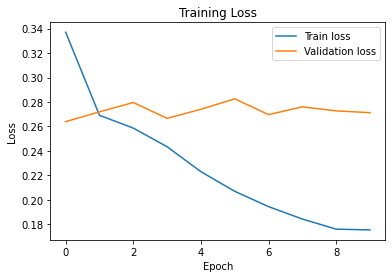

Train	 epoch: 11/30	 batch: 500/2683	 loss: 0.15326079726219177
Train	 epoch: 11/30	 batch: 1000/2683	 loss: 0.1695326268672943
Train	 epoch: 11/30	 batch: 1500/2683	 loss: 0.14322297275066376
Train	 epoch: 11/30	 batch: 2000/2683	 loss: 0.15749064087867737
Train	 epoch: 11/30	 batch: 2500/2683	 loss: 0.13618844747543335
Train	 epoch: 11/30	 loss: 0.1667409391516276
Validation	 epoch: 11/30	 loss: 0.27210189402103424
Saving model


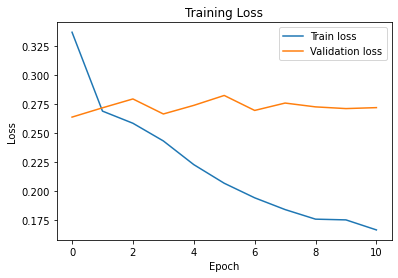

Train	 epoch: 12/30	 batch: 500/2683	 loss: 0.1926001012325287
Train	 epoch: 12/30	 batch: 1000/2683	 loss: 0.15595777332782745
Train	 epoch: 12/30	 batch: 1500/2683	 loss: 0.14828301966190338
Train	 epoch: 12/30	 batch: 2000/2683	 loss: 0.1429123878479004
Train	 epoch: 12/30	 batch: 2500/2683	 loss: 0.18292176723480225
Train	 epoch: 12/30	 loss: 0.16056782082472992
Validation	 epoch: 12/30	 loss: 0.3109728991985321
Saving model


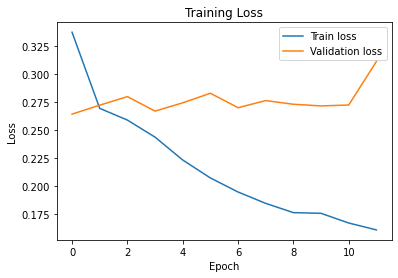

Train	 epoch: 13/30	 batch: 500/2683	 loss: 0.14578555524349213
Train	 epoch: 13/30	 batch: 1000/2683	 loss: 0.15025411546230316
Train	 epoch: 13/30	 batch: 1500/2683	 loss: 0.1686653196811676
Train	 epoch: 13/30	 batch: 2000/2683	 loss: 0.183090940117836
Train	 epoch: 13/30	 batch: 2500/2683	 loss: 0.13693158328533173
Train	 epoch: 13/30	 loss: 0.15513174533788454
Validation	 epoch: 13/30	 loss: 0.27126292884349823
Saving model


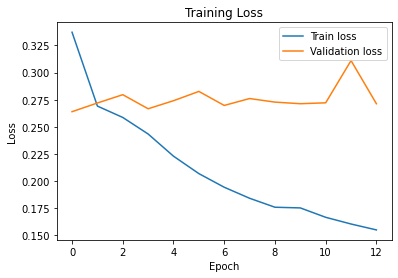

Train	 epoch: 14/30	 batch: 500/2683	 loss: 0.11425770074129105
Train	 epoch: 14/30	 batch: 1000/2683	 loss: 0.13677978515625
Train	 epoch: 14/30	 batch: 1500/2683	 loss: 0.17598526179790497
Train	 epoch: 14/30	 batch: 2000/2683	 loss: 0.15439638495445251
Train	 epoch: 14/30	 batch: 2500/2683	 loss: 0.10902279615402222
Train	 epoch: 14/30	 loss: 0.1500469559759868
Validation	 epoch: 14/30	 loss: 0.27047298848629
Saving model


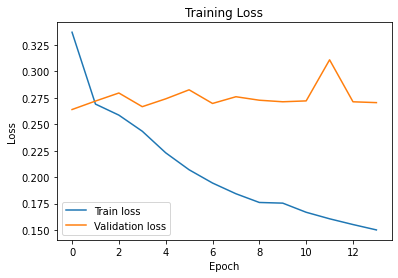

Train	 epoch: 15/30	 batch: 500/2683	 loss: 0.13976484537124634
Train	 epoch: 15/30	 batch: 1000/2683	 loss: 0.11627320200204849
Train	 epoch: 15/30	 batch: 1500/2683	 loss: 0.13228635489940643
Train	 epoch: 15/30	 batch: 2000/2683	 loss: 0.15165841579437256
Train	 epoch: 15/30	 batch: 2500/2683	 loss: 0.1541643738746643
Train	 epoch: 15/30	 loss: 0.14513048047822577
Validation	 epoch: 15/30	 loss: 0.26587431877851486
Saving model


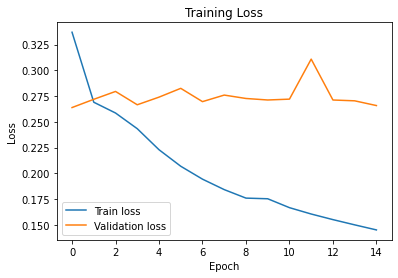

Train	 epoch: 16/30	 batch: 500/2683	 loss: 0.15247584879398346
Train	 epoch: 16/30	 batch: 1000/2683	 loss: 0.13655316829681396
Train	 epoch: 16/30	 batch: 1500/2683	 loss: 0.14709828794002533
Train	 epoch: 16/30	 batch: 2000/2683	 loss: 0.1427450180053711
Train	 epoch: 16/30	 batch: 2500/2683	 loss: 0.16570988297462463
Train	 epoch: 16/30	 loss: 0.14154863723269426
Validation	 epoch: 16/30	 loss: 0.26211627572774887
Saving model


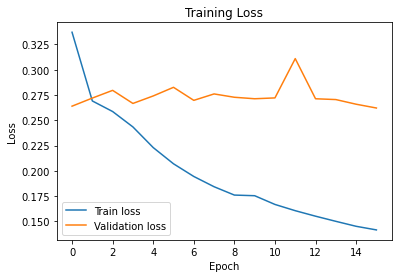

Train	 epoch: 17/30	 batch: 500/2683	 loss: 0.16039863228797913
Train	 epoch: 17/30	 batch: 1000/2683	 loss: 0.14497101306915283
Train	 epoch: 17/30	 batch: 1500/2683	 loss: 0.1365734338760376
Train	 epoch: 17/30	 batch: 2000/2683	 loss: 0.1010316014289856
Train	 epoch: 17/30	 batch: 2500/2683	 loss: 0.1485637128353119
Train	 epoch: 17/30	 loss: 0.13753081392184416
Validation	 epoch: 17/30	 loss: 0.2708630710840225
Saving model


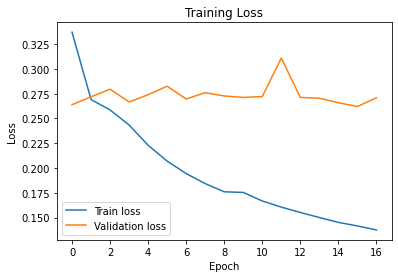

Train	 epoch: 18/30	 batch: 500/2683	 loss: 0.12170088291168213
Train	 epoch: 18/30	 batch: 1000/2683	 loss: 0.13943874835968018
Train	 epoch: 18/30	 batch: 1500/2683	 loss: 0.1254793107509613
Train	 epoch: 18/30	 batch: 2000/2683	 loss: 0.15327680110931396
Train	 epoch: 18/30	 batch: 2500/2683	 loss: 0.1464586853981018
Train	 epoch: 18/30	 loss: 0.1341287141004206
Validation	 epoch: 18/30	 loss: 0.2584226578474045
Saving model


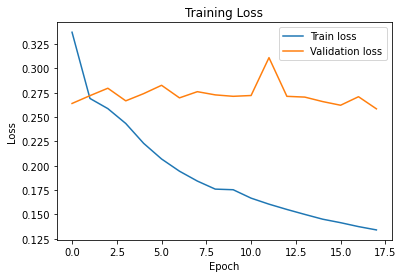

Train	 epoch: 19/30	 batch: 500/2683	 loss: 0.10136506706476212
Train	 epoch: 19/30	 batch: 1000/2683	 loss: 0.15419058501720428
Train	 epoch: 19/30	 batch: 1500/2683	 loss: 0.1342862993478775
Train	 epoch: 19/30	 batch: 2000/2683	 loss: 0.11436797678470612
Train	 epoch: 19/30	 batch: 2500/2683	 loss: 0.13250954449176788
Train	 epoch: 19/30	 loss: 0.13148743002368274
Validation	 epoch: 19/30	 loss: 0.2614683359861374
Saving model


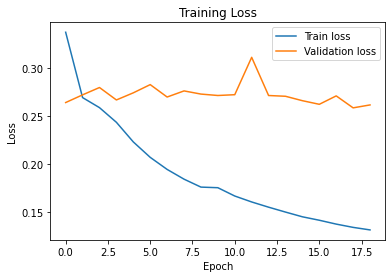

Train	 epoch: 20/30	 batch: 500/2683	 loss: 0.11690334975719452
Train	 epoch: 20/30	 batch: 1000/2683	 loss: 0.1205298900604248
Train	 epoch: 20/30	 batch: 1500/2683	 loss: 0.11527679115533829
Train	 epoch: 20/30	 batch: 2000/2683	 loss: 0.09013723582029343
Train	 epoch: 20/30	 batch: 2500/2683	 loss: 0.12387572228908539
Train	 epoch: 20/30	 loss: 0.12855779807674453
Validation	 epoch: 20/30	 loss: 0.25185494124889374
Saving model


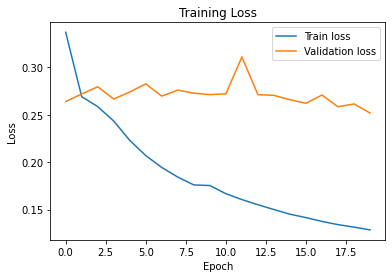

Train	 epoch: 21/30	 batch: 500/2683	 loss: 0.11611250042915344
Train	 epoch: 21/30	 batch: 1000/2683	 loss: 0.11168530583381653
Train	 epoch: 21/30	 batch: 1500/2683	 loss: 0.13047973811626434
Train	 epoch: 21/30	 batch: 2000/2683	 loss: 0.11214172840118408
Train	 epoch: 21/30	 batch: 2500/2683	 loss: 0.0998719334602356
Train	 epoch: 21/30	 loss: 0.12606948513594574
Validation	 epoch: 21/30	 loss: 0.2538398429751396
Saving model


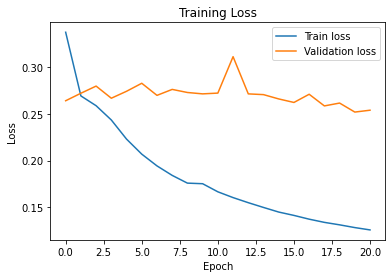

Train	 epoch: 22/30	 batch: 500/2683	 loss: 0.11149998754262924
Train	 epoch: 22/30	 batch: 1000/2683	 loss: 0.11107288300991058
Train	 epoch: 22/30	 batch: 1500/2683	 loss: 0.13319125771522522
Train	 epoch: 22/30	 batch: 2000/2683	 loss: 0.11846501380205154
Train	 epoch: 22/30	 batch: 2500/2683	 loss: 0.13004432618618011
Train	 epoch: 22/30	 loss: 0.12378780536028684
Validation	 epoch: 22/30	 loss: 0.259781576693058
Saving model


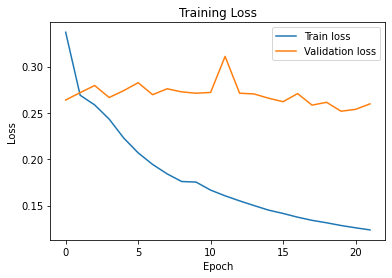

Train	 epoch: 23/30	 batch: 500/2683	 loss: 0.09960279613733292
Train	 epoch: 23/30	 batch: 1000/2683	 loss: 0.10847263038158417
Train	 epoch: 23/30	 batch: 1500/2683	 loss: 0.12941530346870422
Train	 epoch: 23/30	 batch: 2000/2683	 loss: 0.10593060404062271
Train	 epoch: 23/30	 batch: 2500/2683	 loss: 0.16235876083374023
Train	 epoch: 23/30	 loss: 0.12155535933500877
Validation	 epoch: 23/30	 loss: 0.2545623183250427
Saving model


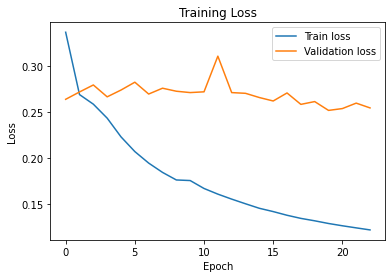

Train	 epoch: 24/30	 batch: 500/2683	 loss: 0.10254555940628052
Train	 epoch: 24/30	 batch: 1000/2683	 loss: 0.1250266134738922
Train	 epoch: 24/30	 batch: 1500/2683	 loss: 0.13118048012256622
Train	 epoch: 24/30	 batch: 2000/2683	 loss: 0.11734476685523987
Train	 epoch: 24/30	 batch: 2500/2683	 loss: 0.11729825288057327
Train	 epoch: 24/30	 loss: 0.11975126685605891
Validation	 epoch: 24/30	 loss: 0.25260841846466064
Saving model


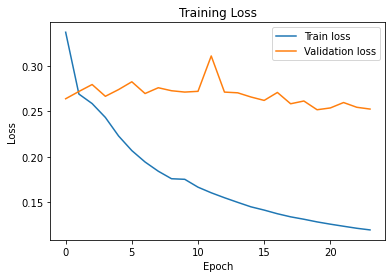

Train	 epoch: 25/30	 batch: 500/2683	 loss: 0.11878086626529694
Train	 epoch: 25/30	 batch: 1000/2683	 loss: 0.12625661492347717
Train	 epoch: 25/30	 batch: 1500/2683	 loss: 0.09134602546691895
Train	 epoch: 25/30	 batch: 2000/2683	 loss: 0.10065442323684692
Train	 epoch: 25/30	 batch: 2500/2683	 loss: 0.09930454194545746
Train	 epoch: 25/30	 loss: 0.11760819987839964
Validation	 epoch: 25/30	 loss: 0.25601619482040405
Saving model


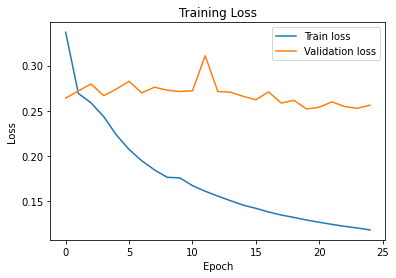

Train	 epoch: 26/30	 batch: 500/2683	 loss: 0.10280826687812805
Train	 epoch: 26/30	 batch: 1000/2683	 loss: 0.1111430674791336
Train	 epoch: 26/30	 batch: 1500/2683	 loss: 0.12066661566495895
Train	 epoch: 26/30	 batch: 2000/2683	 loss: 0.12970617413520813
Train	 epoch: 26/30	 batch: 2500/2683	 loss: 0.1119173914194107
Train	 epoch: 26/30	 loss: 0.11599863691868464
Validation	 epoch: 26/30	 loss: 0.24445027112960815
Saving model


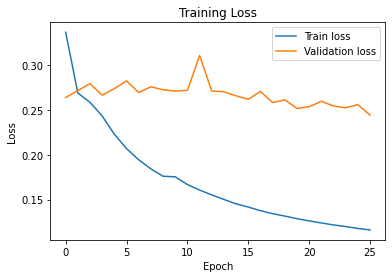

Train	 epoch: 27/30	 batch: 500/2683	 loss: 0.10095606744289398
Train	 epoch: 27/30	 batch: 1000/2683	 loss: 0.10907784104347229
Train	 epoch: 27/30	 batch: 1500/2683	 loss: 0.11538728326559067
Train	 epoch: 27/30	 batch: 2000/2683	 loss: 0.09622391313314438
Train	 epoch: 27/30	 batch: 2500/2683	 loss: 0.10283469408750534
Train	 epoch: 27/30	 loss: 0.11424391640491154
Validation	 epoch: 27/30	 loss: 0.24502405524253845
Saving model


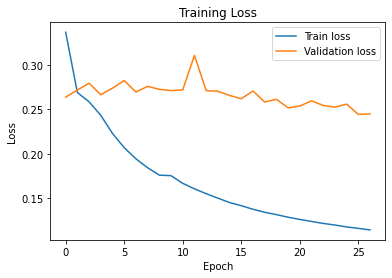

Train	 epoch: 28/30	 batch: 500/2683	 loss: 0.11472836881875992
Train	 epoch: 28/30	 batch: 1000/2683	 loss: 0.11004963517189026
Train	 epoch: 28/30	 batch: 1500/2683	 loss: 0.11947213858366013
Train	 epoch: 28/30	 batch: 2000/2683	 loss: 0.1233704537153244
Train	 epoch: 28/30	 batch: 2500/2683	 loss: 0.12536904215812683
Train	 epoch: 28/30	 loss: 0.11269579809041019
Validation	 epoch: 28/30	 loss: 0.24564295262098312
Saving model


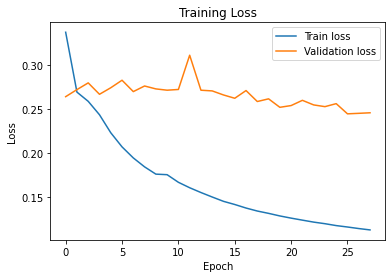

Train	 epoch: 29/30	 batch: 500/2683	 loss: 0.10358958691358566
Train	 epoch: 29/30	 batch: 1000/2683	 loss: 0.08017309755086899
Train	 epoch: 29/30	 batch: 1500/2683	 loss: 0.08445601165294647
Train	 epoch: 29/30	 batch: 2000/2683	 loss: 0.14108827710151672
Train	 epoch: 29/30	 batch: 2500/2683	 loss: 0.12979374825954437
Train	 epoch: 29/30	 loss: 0.11120081677105371
Validation	 epoch: 29/30	 loss: 0.24869036674499512
Saving model


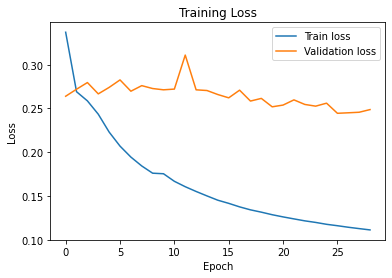

Train	 epoch: 30/30	 batch: 500/2683	 loss: 0.08225839585065842
Train	 epoch: 30/30	 batch: 1000/2683	 loss: 0.11550940573215485
Train	 epoch: 30/30	 batch: 1500/2683	 loss: 0.10435047745704651
Train	 epoch: 30/30	 batch: 2000/2683	 loss: 0.15312425792217255
Train	 epoch: 30/30	 batch: 2500/2683	 loss: 0.12392126023769379
Train	 epoch: 30/30	 loss: 0.1100966980818977
Validation	 epoch: 30/30	 loss: 0.24892579019069672
Saving model


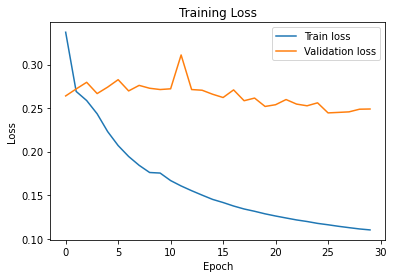

In [15]:
# Train the model
if (model_saved):
  savePath = savePath_base+"Phase1_new_val_2/TTNet_Phase1_9.pth"
  print(f"Loading model from path: {savePath}")
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph1_train_loss_log = checkpoint['train_loss_log']
  ph1_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 1 at epoch {start_epoch} succeed")
else:
  start_epoch = 0
  print("Phase 1: No model to load, start to train at epoch 0")

print("START TO TRAIN PHASE 1: Global Stage ...")
for epoch in range(start_epoch+1, ph1_epochs + 1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()

    # Read in train batch
    window_imgs, xy_downscale, _, _ = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)
    
    # Calculate train (global) loss
    with autocast():
      global_out, _, _, _, _ = model(window_batch)
      train_loss = ball_loss(global_out,xy_downscale) * global_weight

    #train_loss.backward()
    #optimizer.step()
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    
    train_loss_total += loss
    if((i+1)%500==0):
      print(f"Train\t epoch: {epoch}/{ph1_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

  # Log training losses
  print(f"Train\t epoch: {epoch}/{ph1_epochs}\t loss: {train_loss_total/batch_num}")
  ph1_train_loss_log.append(train_loss_total/batch_num)

  model.eval()
  with torch.no_grad():     
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs ,xy_downscale, _,_ = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)      
      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)

      # Model forward step and calculate val (global) loss
      with autocast():
        global_out, _, _, _, _ = model(window_batch)
        val_loss = ball_loss(global_out,xy_downscale) * global_weight
      
      loss = val_loss.detach().cpu().numpy()
      val_loss_total += loss

    # Log validation losses
    ph1_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph1_epochs}\t loss: {val_loss_total/batch_num}")
  
  print("Saving model")
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph1_train_loss_log,'val_loss_log':ph1_val_loss_log}
  savePath = savePath_base+f"/Phase1/TTNet_Phase1_{epoch}.pth"
  torch.save(state, savePath)
  model_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph1_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph1_val_loss_log,label='Validation loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph1.png")
  plt.show()

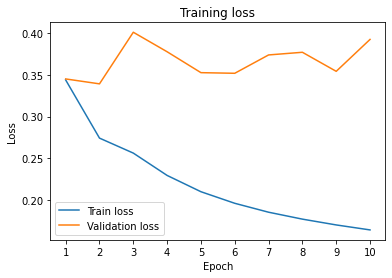

In [20]:
# Plot the losses
plt.clf()
plt.plot(range(epoch),ph1_train_loss_log,label='Train loss')
plt.plot(range(epoch),ph1_val_loss_log,label='Validation loss')
plt.legend()
plt.xticks(range(epoch), range(1,11))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.savefig(outputPath+"loss_ph1.png")
plt.show()

## Training Phase 2

In [13]:
# Training config
ph2_saved = False
ph2_epochs = 30
local_weight = 1
event_weight = 2
ph2_train_loss_log = []
ph2_train_loc_log = []
ph2_train_event_log = []
ph2_val_loss_log = []
ph2_val_loc_log = []
ph2_val_event_log = []

In [14]:
freeze_list = ["global_stage"]
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
model = freeze_model(model,freeze_list)                           
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

# TODO Rewrite this
def load_weights_local_stage(pretrained_dict):
  local_weights_dict = {}
  for layer_name, v in pretrained_dict.items():
    if 'global_stage' in layer_name:
      layer_name_parts = layer_name.split('.')
      layer_name_parts[1] = 'local_stage'
      local_name = '.'.join(layer_name_parts)
      local_weights_dict[local_name] = v

  return {**pretrained_dict, **local_weights_dict}

Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage


Phase 2: No model to load, start to train at epoch 0
START TO TRAIN PHASE 2: Local + Event Stage ...
+ Train	 epoch: 1/30	 batch: 500/5366	 loss: 0.18522348999977112
+ Train	 epoch: 1/30	 batch: 1000/5366	 loss: 0.1942421793937683
+ Train	 epoch: 1/30	 batch: 1500/5366	 loss: 0.19793251156806946
+ Train	 epoch: 1/30	 batch: 2000/5366	 loss: 0.1989925503730774
+ Train	 epoch: 1/30	 batch: 2500/5366	 loss: 0.1767245978116989
+ Train	 epoch: 1/30	 batch: 3000/5366	 loss: 0.2504826784133911
+ Train	 epoch: 1/30	 batch: 3500/5366	 loss: 0.20332524180412292
+ Train	 epoch: 1/30	 batch: 4000/5366	 loss: 0.2132781744003296
+ Train	 epoch: 1/30	 batch: 4500/5366	 loss: 0.2296404242515564
+ Train	 epoch: 1/30	 batch: 5000/5366	 loss: 0.22187116742134094
Train	 epoch: 1/30	 loss: 0.1971225387378944
0.2262095808982849, 0.2262095808982849
0.18301096558570862, 0.18301096558570862
0.202747642993927, 0.202747642993927
0.194379985332489, 0.194379985332489
Validation	 epoch: 1/30	 loss: 0.20158704370260

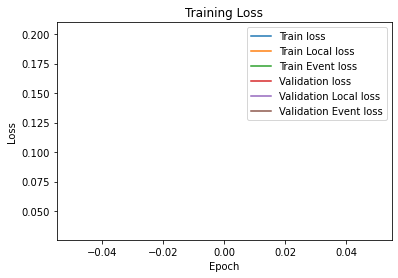

+ Train	 epoch: 2/30	 batch: 500/5366	 loss: 0.19598424434661865
+ Train	 epoch: 2/30	 batch: 1000/5366	 loss: 0.17685101926326752
+ Train	 epoch: 2/30	 batch: 1500/5366	 loss: 0.231525257229805
+ Train	 epoch: 2/30	 batch: 2000/5366	 loss: 0.19636142253875732
+ Train	 epoch: 2/30	 batch: 2500/5366	 loss: 0.20979923009872437
+ Train	 epoch: 2/30	 batch: 3000/5366	 loss: 0.18571367859840393
+ Train	 epoch: 2/30	 batch: 3500/5366	 loss: 0.2268199920654297
+ Train	 epoch: 2/30	 batch: 4000/5366	 loss: 0.22781690955162048
+ Train	 epoch: 2/30	 batch: 4500/5366	 loss: 0.22465160489082336
+ Train	 epoch: 2/30	 batch: 5000/5366	 loss: 0.16003534197807312
Train	 epoch: 2/30	 loss: 0.19132721144463027
0.24272753298282623, 0.24272753298282623
0.18847046792507172, 0.18847046792507172
0.20277704298496246, 0.20277704298496246
0.20213580131530762, 0.20213580131530762
Validation	 epoch: 2/30	 loss: 0.209027711302042
Saving model


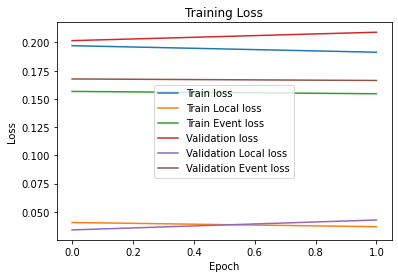

+ Train	 epoch: 3/30	 batch: 500/5366	 loss: 0.16902272403240204
+ Train	 epoch: 3/30	 batch: 1000/5366	 loss: 0.2122620791196823
+ Train	 epoch: 3/30	 batch: 1500/5366	 loss: 0.16779300570487976
+ Train	 epoch: 3/30	 batch: 2000/5366	 loss: 0.2127915918827057
+ Train	 epoch: 3/30	 batch: 2500/5366	 loss: 0.15793529152870178
+ Train	 epoch: 3/30	 batch: 3000/5366	 loss: 0.16133567690849304
+ Train	 epoch: 3/30	 batch: 3500/5366	 loss: 0.19209635257720947
+ Train	 epoch: 3/30	 batch: 4000/5366	 loss: 0.17307719588279724
+ Train	 epoch: 3/30	 batch: 4500/5366	 loss: 0.18032877147197723
+ Train	 epoch: 3/30	 batch: 5000/5366	 loss: 0.18417340517044067
Train	 epoch: 3/30	 loss: 0.18970923643924387
0.2362886518239975, 0.2362886518239975
0.1929878294467926, 0.1929878294467926
0.2130403369665146, 0.2130403369665146
0.21446412801742554, 0.21446412801742554
Validation	 epoch: 3/30	 loss: 0.21419523656368256
Saving model


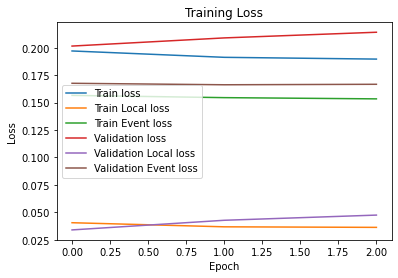

+ Train	 epoch: 4/30	 batch: 500/5366	 loss: 0.18930646777153015
+ Train	 epoch: 4/30	 batch: 1000/5366	 loss: 0.19998764991760254
+ Train	 epoch: 4/30	 batch: 1500/5366	 loss: 0.18578064441680908
+ Train	 epoch: 4/30	 batch: 2000/5366	 loss: 0.17948929965496063
+ Train	 epoch: 4/30	 batch: 2500/5366	 loss: 0.18935121595859528
+ Train	 epoch: 4/30	 batch: 3000/5366	 loss: 0.19318801164627075
+ Train	 epoch: 4/30	 batch: 3500/5366	 loss: 0.1808176338672638
+ Train	 epoch: 4/30	 batch: 4000/5366	 loss: 0.1868211328983307
+ Train	 epoch: 4/30	 batch: 4500/5366	 loss: 0.1495801955461502
+ Train	 epoch: 4/30	 batch: 5000/5366	 loss: 0.1699780821800232
Train	 epoch: 4/30	 loss: 0.1883373371298705
0.22749711573123932, 0.22749711573123932
0.19167828559875488, 0.19167828559875488
0.21453922986984253, 0.21453922986984253
0.2136879861354828, 0.2136879861354828
Validation	 epoch: 4/30	 loss: 0.21185065433382988
Saving model


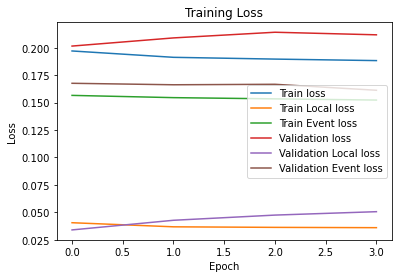

+ Train	 epoch: 5/30	 batch: 500/5366	 loss: 0.1595330685377121
+ Train	 epoch: 5/30	 batch: 1000/5366	 loss: 0.1911972165107727
+ Train	 epoch: 5/30	 batch: 1500/5366	 loss: 0.17820191383361816
+ Train	 epoch: 5/30	 batch: 2000/5366	 loss: 0.1672254055738449
+ Train	 epoch: 5/30	 batch: 2500/5366	 loss: 0.16204503178596497
+ Train	 epoch: 5/30	 batch: 3000/5366	 loss: 0.24214306473731995
+ Train	 epoch: 5/30	 batch: 3500/5366	 loss: 0.17335382103919983
+ Train	 epoch: 5/30	 batch: 4000/5366	 loss: 0.15818896889686584
+ Train	 epoch: 5/30	 batch: 4500/5366	 loss: 0.16404156386852264
+ Train	 epoch: 5/30	 batch: 5000/5366	 loss: 0.15833640098571777
Train	 epoch: 5/30	 loss: 0.18733300134522943
0.22614410519599915, 0.22614410519599915
0.1891069859266281, 0.1891069859266281
0.2000303417444229, 0.2000303417444229
0.19885091483592987, 0.19885091483592987
Validation	 epoch: 5/30	 loss: 0.203533086925745
Saving model


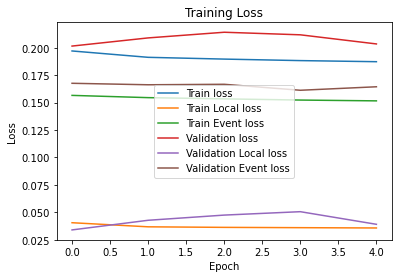

+ Train	 epoch: 6/30	 batch: 500/5366	 loss: 0.196513369679451
+ Train	 epoch: 6/30	 batch: 1000/5366	 loss: 0.17624521255493164
+ Train	 epoch: 6/30	 batch: 1500/5366	 loss: 0.1972251683473587
+ Train	 epoch: 6/30	 batch: 2000/5366	 loss: 0.2166358232498169
+ Train	 epoch: 6/30	 batch: 2500/5366	 loss: 0.1955367922782898
+ Train	 epoch: 6/30	 batch: 3000/5366	 loss: 0.1997469663619995
+ Train	 epoch: 6/30	 batch: 3500/5366	 loss: 0.1536690592765808
+ Train	 epoch: 6/30	 batch: 4000/5366	 loss: 0.16162876784801483
+ Train	 epoch: 6/30	 batch: 4500/5366	 loss: 0.1708955466747284
+ Train	 epoch: 6/30	 batch: 5000/5366	 loss: 0.18857862055301666
Train	 epoch: 6/30	 loss: 0.1863518834497295
0.2197466492652893, 0.2197466492652893
0.1838749796152115, 0.1838749796152115
0.1884879767894745, 0.1884879767894745
0.1961965262889862, 0.1961965262889862
Validation	 epoch: 6/30	 loss: 0.19707653298974037
Saving model


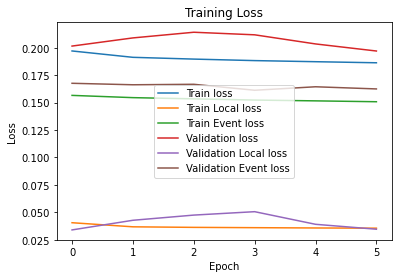

+ Train	 epoch: 7/30	 batch: 500/5366	 loss: 0.19990241527557373
+ Train	 epoch: 7/30	 batch: 1000/5366	 loss: 0.19088441133499146
+ Train	 epoch: 7/30	 batch: 1500/5366	 loss: 0.18715591728687286
+ Train	 epoch: 7/30	 batch: 2000/5366	 loss: 0.19764725863933563
+ Train	 epoch: 7/30	 batch: 2500/5366	 loss: 0.17992553114891052
+ Train	 epoch: 7/30	 batch: 3000/5366	 loss: 0.22319619357585907
+ Train	 epoch: 7/30	 batch: 3500/5366	 loss: 0.20055949687957764
+ Train	 epoch: 7/30	 batch: 4000/5366	 loss: 0.1840350478887558
+ Train	 epoch: 7/30	 batch: 4500/5366	 loss: 0.15424656867980957
+ Train	 epoch: 7/30	 batch: 5000/5366	 loss: 0.16768042743206024
Train	 epoch: 7/30	 loss: 0.1854248473582497
0.21537815034389496, 0.21537815034389496
0.1815716028213501, 0.1815716028213501
0.18949291110038757, 0.18949291110038757
0.19146113097667694, 0.19146113097667694
Validation	 epoch: 7/30	 loss: 0.1944759488105774
Saving model


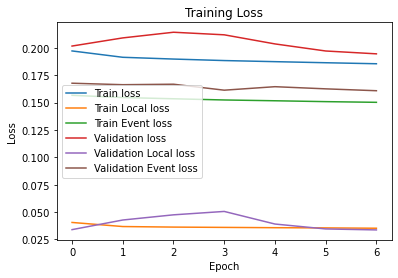

+ Train	 epoch: 8/30	 batch: 500/5366	 loss: 0.19921165704727173
+ Train	 epoch: 8/30	 batch: 1000/5366	 loss: 0.17181184887886047
+ Train	 epoch: 8/30	 batch: 1500/5366	 loss: 0.21296003460884094
+ Train	 epoch: 8/30	 batch: 2000/5366	 loss: 0.19410353899002075
+ Train	 epoch: 8/30	 batch: 2500/5366	 loss: 0.20413757860660553
+ Train	 epoch: 8/30	 batch: 3000/5366	 loss: 0.16729998588562012
+ Train	 epoch: 8/30	 batch: 3500/5366	 loss: 0.1844244748353958
+ Train	 epoch: 8/30	 batch: 4000/5366	 loss: 0.21001970767974854
+ Train	 epoch: 8/30	 batch: 4500/5366	 loss: 0.1626180112361908
+ Train	 epoch: 8/30	 batch: 5000/5366	 loss: 0.1657690852880478
Train	 epoch: 8/30	 loss: 0.18471674411722497
0.21910890936851501, 0.21910890936851501
0.18313921988010406, 0.18313921988010406
0.19842801988124847, 0.19842801988124847
0.2014409452676773, 0.2014409452676773
Validation	 epoch: 8/30	 loss: 0.20052927359938622
Saving model


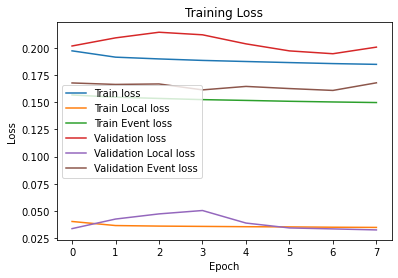

+ Train	 epoch: 9/30	 batch: 500/5366	 loss: 0.18433529138565063
+ Train	 epoch: 9/30	 batch: 1000/5366	 loss: 0.16265767812728882
+ Train	 epoch: 9/30	 batch: 1500/5366	 loss: 0.177372545003891
+ Train	 epoch: 9/30	 batch: 2000/5366	 loss: 0.1783166527748108
+ Train	 epoch: 9/30	 batch: 2500/5366	 loss: 0.18977652490139008
+ Train	 epoch: 9/30	 batch: 3000/5366	 loss: 0.1678614318370819
+ Train	 epoch: 9/30	 batch: 3500/5366	 loss: 0.17575889825820923
+ Train	 epoch: 9/30	 batch: 4000/5366	 loss: 0.22713719308376312
+ Train	 epoch: 9/30	 batch: 4500/5366	 loss: 0.16039730608463287
+ Train	 epoch: 9/30	 batch: 5000/5366	 loss: 0.22666522860527039
Train	 epoch: 9/30	 loss: 0.18392377483380448
0.23696845769882202, 0.23696845769882202
0.1772826761007309, 0.1772826761007309
0.18368183076381683, 0.18368183076381683
0.18908905982971191, 0.18908905982971191
Validation	 epoch: 9/30	 loss: 0.19675550609827042
Saving model


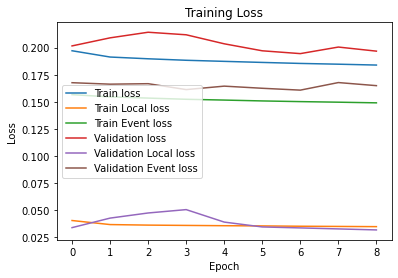

+ Train	 epoch: 10/30	 batch: 500/5366	 loss: 0.20220130681991577
+ Train	 epoch: 10/30	 batch: 1000/5366	 loss: 0.232160747051239
+ Train	 epoch: 10/30	 batch: 1500/5366	 loss: 0.16041423380374908
+ Train	 epoch: 10/30	 batch: 2000/5366	 loss: 0.16094477474689484
+ Train	 epoch: 10/30	 batch: 2500/5366	 loss: 0.18638688325881958
+ Train	 epoch: 10/30	 batch: 3000/5366	 loss: 0.19911842048168182
+ Train	 epoch: 10/30	 batch: 3500/5366	 loss: 0.15997377038002014
+ Train	 epoch: 10/30	 batch: 4000/5366	 loss: 0.16921107470989227
+ Train	 epoch: 10/30	 batch: 4500/5366	 loss: 0.19080014526844025
+ Train	 epoch: 10/30	 batch: 5000/5366	 loss: 0.19754046201705933
Train	 epoch: 10/30	 loss: 0.18329183619567987
0.21633651852607727, 0.21633651852607727
0.1808953881263733, 0.1808953881263733
0.18879170715808868, 0.18879170715808868
0.18619243800640106, 0.18619243800640106
Validation	 epoch: 10/30	 loss: 0.19305401295423508
Saving model


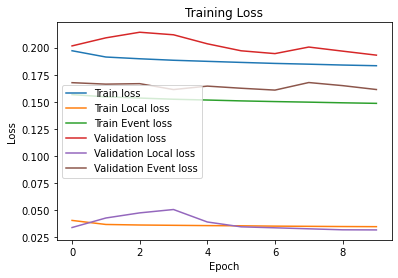

+ Train	 epoch: 11/30	 batch: 500/5366	 loss: 0.1729578822851181
+ Train	 epoch: 11/30	 batch: 1000/5366	 loss: 0.1581750214099884
+ Train	 epoch: 11/30	 batch: 1500/5366	 loss: 0.17601913213729858
+ Train	 epoch: 11/30	 batch: 2000/5366	 loss: 0.1633691042661667
+ Train	 epoch: 11/30	 batch: 2500/5366	 loss: 0.16588419675827026
+ Train	 epoch: 11/30	 batch: 3000/5366	 loss: 0.18124285340309143
+ Train	 epoch: 11/30	 batch: 3500/5366	 loss: 0.21898607909679413
+ Train	 epoch: 11/30	 batch: 4000/5366	 loss: 0.17695172131061554
+ Train	 epoch: 11/30	 batch: 4500/5366	 loss: 0.157940074801445
+ Train	 epoch: 11/30	 batch: 5000/5366	 loss: 0.1717902421951294
Train	 epoch: 11/30	 loss: 0.18287774439216592
0.24271635711193085, 0.24271635711193085
0.18004071712493896, 0.18004071712493896
0.18922430276870728, 0.18922430276870728
0.1870441734790802, 0.1870441734790802
Validation	 epoch: 11/30	 loss: 0.19975638762116432
Saving model


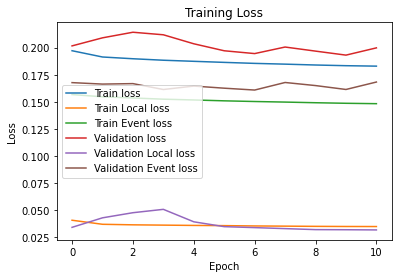

+ Train	 epoch: 12/30	 batch: 500/5366	 loss: 0.17878064513206482
+ Train	 epoch: 12/30	 batch: 1000/5366	 loss: 0.1703176498413086
+ Train	 epoch: 12/30	 batch: 1500/5366	 loss: 0.18171653151512146
+ Train	 epoch: 12/30	 batch: 2000/5366	 loss: 0.18020451068878174
+ Train	 epoch: 12/30	 batch: 2500/5366	 loss: 0.17960338294506073
+ Train	 epoch: 12/30	 batch: 3000/5366	 loss: 0.16694563627243042
+ Train	 epoch: 12/30	 batch: 3500/5366	 loss: 0.18870770931243896
+ Train	 epoch: 12/30	 batch: 4000/5366	 loss: 0.2067977488040924
+ Train	 epoch: 12/30	 batch: 4500/5366	 loss: 0.16370481252670288
+ Train	 epoch: 12/30	 batch: 5000/5366	 loss: 0.16659389436244965
Train	 epoch: 12/30	 loss: 0.1823418861893056
0.23897801339626312, 0.23897801339626312
0.1797586977481842, 0.1797586977481842
0.1877468228340149, 0.1877468228340149
0.19392114877700806, 0.19392114877700806
Validation	 epoch: 12/30	 loss: 0.20010117068886757
Saving model


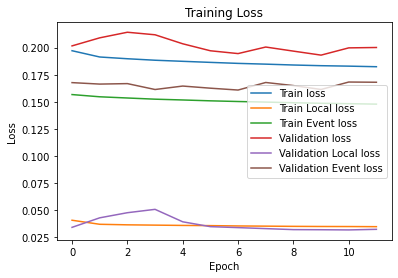

+ Train	 epoch: 13/30	 batch: 500/5366	 loss: 0.15541453659534454
+ Train	 epoch: 13/30	 batch: 1000/5366	 loss: 0.20160597562789917
+ Train	 epoch: 13/30	 batch: 1500/5366	 loss: 0.18476659059524536
+ Train	 epoch: 13/30	 batch: 2000/5366	 loss: 0.1965050995349884
+ Train	 epoch: 13/30	 batch: 2500/5366	 loss: 0.17804107069969177
+ Train	 epoch: 13/30	 batch: 3000/5366	 loss: 0.18430295586585999
+ Train	 epoch: 13/30	 batch: 3500/5366	 loss: 0.1872928887605667
+ Train	 epoch: 13/30	 batch: 4000/5366	 loss: 0.21770378947257996
+ Train	 epoch: 13/30	 batch: 4500/5366	 loss: 0.1655227094888687
+ Train	 epoch: 13/30	 batch: 5000/5366	 loss: 0.1883038431406021
Train	 epoch: 13/30	 loss: 0.1818751314022494
0.23263168334960938, 0.23263168334960938
0.17924605309963226, 0.17924605309963226
0.1831047087907791, 0.1831047087907791
0.18746264278888702, 0.18746264278888702
Validation	 epoch: 13/30	 loss: 0.19561127200722694
Saving model


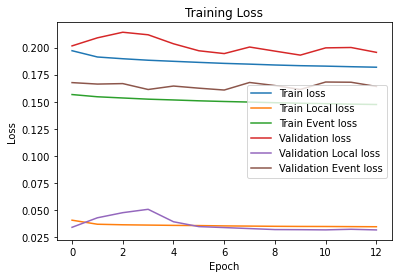

+ Train	 epoch: 14/30	 batch: 500/5366	 loss: 0.20566338300704956
+ Train	 epoch: 14/30	 batch: 1000/5366	 loss: 0.1947888433933258
+ Train	 epoch: 14/30	 batch: 1500/5366	 loss: 0.20665454864501953
+ Train	 epoch: 14/30	 batch: 2000/5366	 loss: 0.18305794894695282
+ Train	 epoch: 14/30	 batch: 2500/5366	 loss: 0.17898550629615784
+ Train	 epoch: 14/30	 batch: 3000/5366	 loss: 0.20335203409194946
+ Train	 epoch: 14/30	 batch: 3500/5366	 loss: 0.18012259900569916
+ Train	 epoch: 14/30	 batch: 4000/5366	 loss: 0.1800883412361145
+ Train	 epoch: 14/30	 batch: 4500/5366	 loss: 0.16720417141914368
+ Train	 epoch: 14/30	 batch: 5000/5366	 loss: 0.16416648030281067
Train	 epoch: 14/30	 loss: 0.1815014389599387
0.23129740357398987, 0.23129740357398987
0.17717233300209045, 0.17717233300209045
0.18357831239700317, 0.18357831239700317
0.19241105020046234, 0.19241105020046234
Validation	 epoch: 14/30	 loss: 0.19611477479338646
Saving model


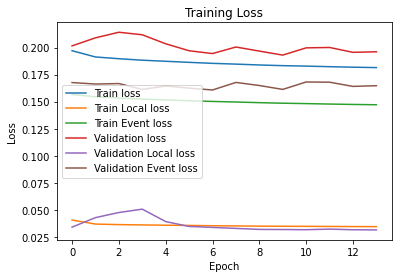

+ Train	 epoch: 15/30	 batch: 500/5366	 loss: 0.15996089577674866
+ Train	 epoch: 15/30	 batch: 1000/5366	 loss: 0.17359799146652222
+ Train	 epoch: 15/30	 batch: 1500/5366	 loss: 0.18524062633514404
+ Train	 epoch: 15/30	 batch: 2000/5366	 loss: 0.18682031333446503
+ Train	 epoch: 15/30	 batch: 2500/5366	 loss: 0.24268019199371338
+ Train	 epoch: 15/30	 batch: 3000/5366	 loss: 0.15138015151023865
+ Train	 epoch: 15/30	 batch: 3500/5366	 loss: 0.19396336376667023
+ Train	 epoch: 15/30	 batch: 4000/5366	 loss: 0.16879069805145264
+ Train	 epoch: 15/30	 batch: 4500/5366	 loss: 0.1545620560646057
+ Train	 epoch: 15/30	 batch: 5000/5366	 loss: 0.2047998458147049
Train	 epoch: 15/30	 loss: 0.1811604043034933
0.23931622505187988, 0.23931622505187988
0.18238037824630737, 0.18238037824630737
0.1891547441482544, 0.1891547441482544
0.1888335794210434, 0.1888335794210434
Validation	 epoch: 15/30	 loss: 0.19992123171687126
Saving model


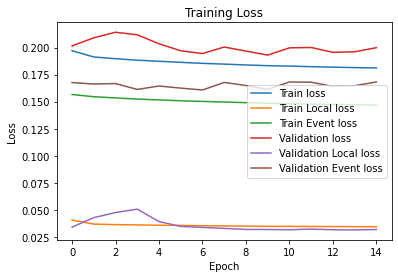

+ Train	 epoch: 16/30	 batch: 500/5366	 loss: 0.16485092043876648
+ Train	 epoch: 16/30	 batch: 1000/5366	 loss: 0.18164484202861786
+ Train	 epoch: 16/30	 batch: 1500/5366	 loss: 0.19800730049610138
+ Train	 epoch: 16/30	 batch: 2000/5366	 loss: 0.1689278483390808
+ Train	 epoch: 16/30	 batch: 2500/5366	 loss: 0.1890522688627243
+ Train	 epoch: 16/30	 batch: 3000/5366	 loss: 0.18232275545597076
+ Train	 epoch: 16/30	 batch: 3500/5366	 loss: 0.1697089970111847
+ Train	 epoch: 16/30	 batch: 4000/5366	 loss: 0.15833993256092072
+ Train	 epoch: 16/30	 batch: 4500/5366	 loss: 0.18735384941101074
+ Train	 epoch: 16/30	 batch: 5000/5366	 loss: 0.1722811609506607
Train	 epoch: 16/30	 loss: 0.18072610319027294
0.22723600268363953, 0.22723600268363953
0.1788610965013504, 0.1788610965013504
0.18952682614326477, 0.18952682614326477
0.1783556342124939, 0.1783556342124939
Validation	 epoch: 16/30	 loss: 0.19349488988518715
Saving model


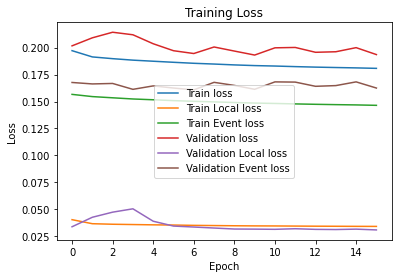

+ Train	 epoch: 17/30	 batch: 500/5366	 loss: 0.23896285891532898
+ Train	 epoch: 17/30	 batch: 1000/5366	 loss: 0.16972751915454865
+ Train	 epoch: 17/30	 batch: 1500/5366	 loss: 0.16202381253242493
+ Train	 epoch: 17/30	 batch: 2000/5366	 loss: 0.16429124772548676
+ Train	 epoch: 17/30	 batch: 2500/5366	 loss: 0.17511190474033356
+ Train	 epoch: 17/30	 batch: 3000/5366	 loss: 0.17559511959552765
+ Train	 epoch: 17/30	 batch: 3500/5366	 loss: 0.17380273342132568
+ Train	 epoch: 17/30	 batch: 4000/5366	 loss: 0.16192488372325897
+ Train	 epoch: 17/30	 batch: 4500/5366	 loss: 0.16459128260612488
+ Train	 epoch: 17/30	 batch: 5000/5366	 loss: 0.193662628531456
Train	 epoch: 17/30	 loss: 0.18044287758034822
0.24477934837341309, 0.24477934837341309
0.1773970127105713, 0.1773970127105713
0.18191997706890106, 0.18191997706890106
0.186628520488739, 0.186628520488739
Validation	 epoch: 17/30	 loss: 0.1976812146604061
Saving model


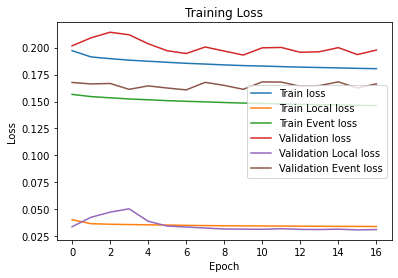

+ Train	 epoch: 18/30	 batch: 500/5366	 loss: 0.15913337469100952
+ Train	 epoch: 18/30	 batch: 1000/5366	 loss: 0.2192380279302597
+ Train	 epoch: 18/30	 batch: 1500/5366	 loss: 0.1810978204011917
+ Train	 epoch: 18/30	 batch: 2000/5366	 loss: 0.17387892305850983
+ Train	 epoch: 18/30	 batch: 2500/5366	 loss: 0.18198587000370026
+ Train	 epoch: 18/30	 batch: 3000/5366	 loss: 0.1967518925666809
+ Train	 epoch: 18/30	 batch: 3500/5366	 loss: 0.1787034571170807
+ Train	 epoch: 18/30	 batch: 4000/5366	 loss: 0.17766328155994415
+ Train	 epoch: 18/30	 batch: 4500/5366	 loss: 0.19252488017082214
+ Train	 epoch: 18/30	 batch: 5000/5366	 loss: 0.1763143539428711
Train	 epoch: 18/30	 loss: 0.18011861727158168
0.23176530003547668, 0.23176530003547668
0.17907200753688812, 0.17907200753688812
0.1838957816362381, 0.1838957816362381
0.18255256116390228, 0.18255256116390228
Validation	 epoch: 18/30	 loss: 0.1943214125931263
Saving model


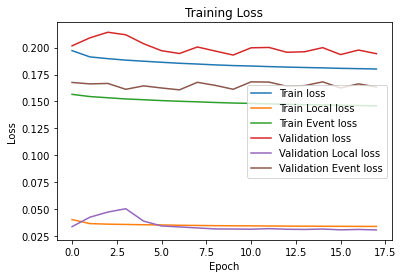

+ Train	 epoch: 19/30	 batch: 500/5366	 loss: 0.16273635625839233
+ Train	 epoch: 19/30	 batch: 1000/5366	 loss: 0.19150114059448242
+ Train	 epoch: 19/30	 batch: 1500/5366	 loss: 0.1854497492313385
+ Train	 epoch: 19/30	 batch: 2000/5366	 loss: 0.17081929743289948
+ Train	 epoch: 19/30	 batch: 2500/5366	 loss: 0.1775015890598297
+ Train	 epoch: 19/30	 batch: 3000/5366	 loss: 0.17867593467235565
+ Train	 epoch: 19/30	 batch: 3500/5366	 loss: 0.22101563215255737
+ Train	 epoch: 19/30	 batch: 4000/5366	 loss: 0.19278088212013245
+ Train	 epoch: 19/30	 batch: 4500/5366	 loss: 0.2017088532447815
+ Train	 epoch: 19/30	 batch: 5000/5366	 loss: 0.15546053647994995
Train	 epoch: 19/30	 loss: 0.17967968915897745
0.2277991771697998, 0.2277991771697998
0.1796835958957672, 0.1796835958957672
0.18451204895973206, 0.18451204895973206
0.18071793019771576, 0.18071793019771576
Validation	 epoch: 19/30	 loss: 0.1931781880557537
Saving model


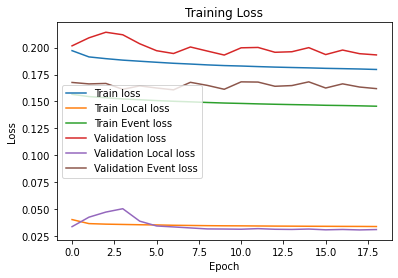

+ Train	 epoch: 20/30	 batch: 500/5366	 loss: 0.1671922653913498
+ Train	 epoch: 20/30	 batch: 1000/5366	 loss: 0.19477403163909912
+ Train	 epoch: 20/30	 batch: 1500/5366	 loss: 0.1756778359413147
+ Train	 epoch: 20/30	 batch: 2000/5366	 loss: 0.17621877789497375
+ Train	 epoch: 20/30	 batch: 2500/5366	 loss: 0.23098105192184448
+ Train	 epoch: 20/30	 batch: 3000/5366	 loss: 0.19047264754772186
+ Train	 epoch: 20/30	 batch: 3500/5366	 loss: 0.16075211763381958
+ Train	 epoch: 20/30	 batch: 4000/5366	 loss: 0.19016028940677643
+ Train	 epoch: 20/30	 batch: 4500/5366	 loss: 0.16058215498924255
+ Train	 epoch: 20/30	 batch: 5000/5366	 loss: 0.16847774386405945
Train	 epoch: 20/30	 loss: 0.17951591609742185
0.21264877915382385, 0.21264877915382385
0.17942696809768677, 0.17942696809768677
0.1841241717338562, 0.1841241717338562
0.19402901828289032, 0.19402901828289032
Validation	 epoch: 20/30	 loss: 0.19255723431706429
Saving model


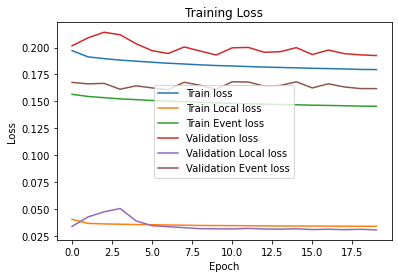

+ Train	 epoch: 21/30	 batch: 500/5366	 loss: 0.20002347230911255
+ Train	 epoch: 21/30	 batch: 1000/5366	 loss: 0.18103797733783722
+ Train	 epoch: 21/30	 batch: 1500/5366	 loss: 0.15891335904598236
+ Train	 epoch: 21/30	 batch: 2000/5366	 loss: 0.1644206941127777
+ Train	 epoch: 21/30	 batch: 2500/5366	 loss: 0.17044703662395477
+ Train	 epoch: 21/30	 batch: 3000/5366	 loss: 0.16341878473758698
+ Train	 epoch: 21/30	 batch: 3500/5366	 loss: 0.19490832090377808
+ Train	 epoch: 21/30	 batch: 4000/5366	 loss: 0.17164582014083862
+ Train	 epoch: 21/30	 batch: 4500/5366	 loss: 0.17239901423454285
+ Train	 epoch: 21/30	 batch: 5000/5366	 loss: 0.15297894179821014
Train	 epoch: 21/30	 loss: 0.17925872044735688
0.24250073730945587, 0.24250073730945587
0.17680664360523224, 0.17680664360523224
0.1836847960948944, 0.1836847960948944
0.1852439045906067, 0.1852439045906067
Validation	 epoch: 21/30	 loss: 0.1970590204000473
Saving model


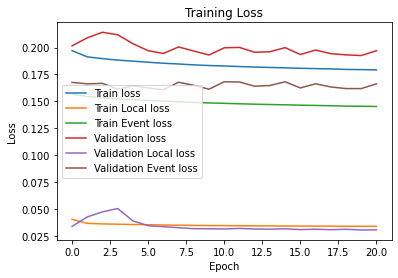

+ Train	 epoch: 22/30	 batch: 500/5366	 loss: 0.211442232131958
+ Train	 epoch: 22/30	 batch: 1000/5366	 loss: 0.16869597136974335
+ Train	 epoch: 22/30	 batch: 1500/5366	 loss: 0.18773338198661804
+ Train	 epoch: 22/30	 batch: 2000/5366	 loss: 0.1752088963985443
+ Train	 epoch: 22/30	 batch: 2500/5366	 loss: 0.20323795080184937
+ Train	 epoch: 22/30	 batch: 3000/5366	 loss: 0.15754830837249756
+ Train	 epoch: 22/30	 batch: 3500/5366	 loss: 0.1929875612258911
+ Train	 epoch: 22/30	 batch: 4000/5366	 loss: 0.17820575833320618
+ Train	 epoch: 22/30	 batch: 4500/5366	 loss: 0.17142340540885925
+ Train	 epoch: 22/30	 batch: 5000/5366	 loss: 0.1735474318265915
Train	 epoch: 22/30	 loss: 0.17890330217431563
0.22694408893585205, 0.22694408893585205
0.17638473212718964, 0.17638473212718964
0.18264144659042358, 0.18264144659042358
0.1820082813501358, 0.1820082813501358
Validation	 epoch: 22/30	 loss: 0.19199463725090027
Saving model


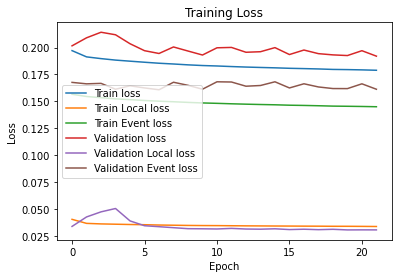

+ Train	 epoch: 23/30	 batch: 500/5366	 loss: 0.17692899703979492
+ Train	 epoch: 23/30	 batch: 1000/5366	 loss: 0.20325005054473877
+ Train	 epoch: 23/30	 batch: 1500/5366	 loss: 0.15988023579120636
+ Train	 epoch: 23/30	 batch: 2000/5366	 loss: 0.1824175864458084
+ Train	 epoch: 23/30	 batch: 2500/5366	 loss: 0.15786486864089966
+ Train	 epoch: 23/30	 batch: 3000/5366	 loss: 0.18731382489204407
+ Train	 epoch: 23/30	 batch: 3500/5366	 loss: 0.15874268114566803
+ Train	 epoch: 23/30	 batch: 4000/5366	 loss: 0.16206538677215576
+ Train	 epoch: 23/30	 batch: 4500/5366	 loss: 0.16044723987579346
+ Train	 epoch: 23/30	 batch: 5000/5366	 loss: 0.19410735368728638
Train	 epoch: 23/30	 loss: 0.1786017293722115
0.22352325916290283, 0.22352325916290283
0.17684587836265564, 0.17684587836265564
0.18188542127609253, 0.18188542127609253
0.18612350523471832, 0.18612350523471832
Validation	 epoch: 23/30	 loss: 0.19209451600909233
Saving model


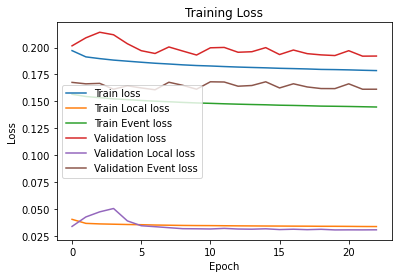

+ Train	 epoch: 24/30	 batch: 500/5366	 loss: 0.20499485731124878
+ Train	 epoch: 24/30	 batch: 1000/5366	 loss: 0.1682421863079071
+ Train	 epoch: 24/30	 batch: 1500/5366	 loss: 0.17169776558876038
+ Train	 epoch: 24/30	 batch: 2000/5366	 loss: 0.1889108270406723
+ Train	 epoch: 24/30	 batch: 2500/5366	 loss: 0.17794100940227509
+ Train	 epoch: 24/30	 batch: 3000/5366	 loss: 0.18401029706001282
+ Train	 epoch: 24/30	 batch: 3500/5366	 loss: 0.1755046546459198
+ Train	 epoch: 24/30	 batch: 4000/5366	 loss: 0.17083026468753815
+ Train	 epoch: 24/30	 batch: 4500/5366	 loss: 0.19856616854667664
+ Train	 epoch: 24/30	 batch: 5000/5366	 loss: 0.19672006368637085
Train	 epoch: 24/30	 loss: 0.1783147377395559
0.20611245930194855, 0.20611245930194855
0.18258096277713776, 0.18258096277713776
0.18601930141448975, 0.18601930141448975
0.18262004852294922, 0.18262004852294922
Validation	 epoch: 24/30	 loss: 0.18933319300413132
Saving model


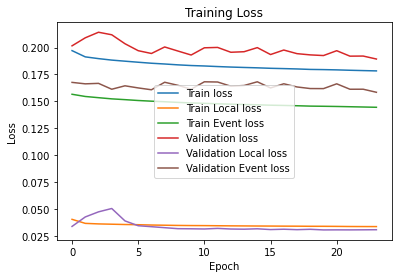

+ Train	 epoch: 25/30	 batch: 500/5366	 loss: 0.175913468003273
+ Train	 epoch: 25/30	 batch: 1000/5366	 loss: 0.17148634791374207
+ Train	 epoch: 25/30	 batch: 1500/5366	 loss: 0.16419054567813873
+ Train	 epoch: 25/30	 batch: 2000/5366	 loss: 0.1694004237651825
+ Train	 epoch: 25/30	 batch: 2500/5366	 loss: 0.19642393290996552
+ Train	 epoch: 25/30	 batch: 3000/5366	 loss: 0.16009970009326935
+ Train	 epoch: 25/30	 batch: 3500/5366	 loss: 0.16873866319656372
+ Train	 epoch: 25/30	 batch: 4000/5366	 loss: 0.1502334326505661
+ Train	 epoch: 25/30	 batch: 4500/5366	 loss: 0.16866172850131989
+ Train	 epoch: 25/30	 batch: 5000/5366	 loss: 0.17922775447368622
Train	 epoch: 25/30	 loss: 0.17801407114243356
0.22339430451393127, 0.22339430451393127
0.18094362318515778, 0.18094362318515778
0.18242640793323517, 0.18242640793323517
0.18476897478103638, 0.18476897478103638
Validation	 epoch: 25/30	 loss: 0.19288332760334015
Saving model


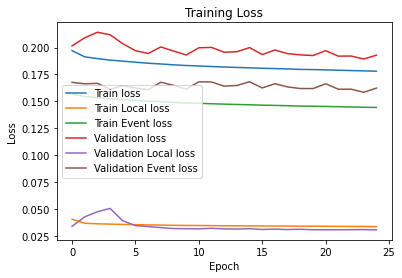

+ Train	 epoch: 26/30	 batch: 500/5366	 loss: 0.20365455746650696
+ Train	 epoch: 26/30	 batch: 1000/5366	 loss: 0.16845138370990753
+ Train	 epoch: 26/30	 batch: 1500/5366	 loss: 0.1698811948299408
+ Train	 epoch: 26/30	 batch: 2000/5366	 loss: 0.1864543855190277
+ Train	 epoch: 26/30	 batch: 2500/5366	 loss: 0.1626642793416977
+ Train	 epoch: 26/30	 batch: 3000/5366	 loss: 0.15715360641479492
+ Train	 epoch: 26/30	 batch: 3500/5366	 loss: 0.2024194449186325
+ Train	 epoch: 26/30	 batch: 4000/5366	 loss: 0.16180439293384552
+ Train	 epoch: 26/30	 batch: 4500/5366	 loss: 0.1674812138080597
+ Train	 epoch: 26/30	 batch: 5000/5366	 loss: 0.17644712328910828
Train	 epoch: 26/30	 loss: 0.1778424478903485
0.21755704283714294, 0.21755704283714294
0.1767314076423645, 0.1767314076423645
0.18421636521816254, 0.18421636521816254
0.1944401115179062, 0.1944401115179062
Validation	 epoch: 26/30	 loss: 0.19323623180389404
Saving model


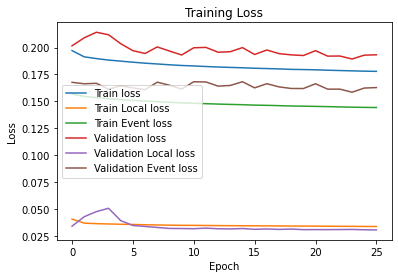

+ Train	 epoch: 27/30	 batch: 500/5366	 loss: 0.18818265199661255
+ Train	 epoch: 27/30	 batch: 1000/5366	 loss: 0.17071063816547394
+ Train	 epoch: 27/30	 batch: 1500/5366	 loss: 0.17687202990055084
+ Train	 epoch: 27/30	 batch: 2000/5366	 loss: 0.18656331300735474
+ Train	 epoch: 27/30	 batch: 2500/5366	 loss: 0.16765786707401276
+ Train	 epoch: 27/30	 batch: 3000/5366	 loss: 0.1857001632452011
+ Train	 epoch: 27/30	 batch: 3500/5366	 loss: 0.15494892001152039
+ Train	 epoch: 27/30	 batch: 4000/5366	 loss: 0.16914263367652893
+ Train	 epoch: 27/30	 batch: 4500/5366	 loss: 0.18049490451812744
+ Train	 epoch: 27/30	 batch: 5000/5366	 loss: 0.17269988358020782
Train	 epoch: 27/30	 loss: 0.1775318956057438
0.2251298576593399, 0.2251298576593399
0.17421554028987885, 0.17421554028987885
0.18064983189105988, 0.18064983189105988
0.1803719699382782, 0.1803719699382782
Validation	 epoch: 27/30	 loss: 0.1900917999446392
Saving model


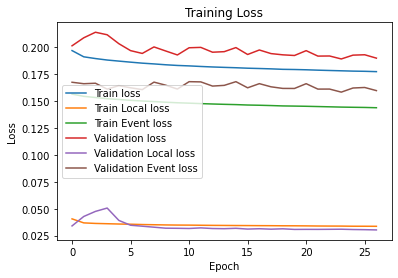

+ Train	 epoch: 28/30	 batch: 500/5366	 loss: 0.16318590939044952
+ Train	 epoch: 28/30	 batch: 1000/5366	 loss: 0.16096234321594238
+ Train	 epoch: 28/30	 batch: 1500/5366	 loss: 0.1561061590909958
+ Train	 epoch: 28/30	 batch: 2000/5366	 loss: 0.22305607795715332
+ Train	 epoch: 28/30	 batch: 2500/5366	 loss: 0.16323578357696533
+ Train	 epoch: 28/30	 batch: 3000/5366	 loss: 0.1802634745836258
+ Train	 epoch: 28/30	 batch: 3500/5366	 loss: 0.1716749519109726
+ Train	 epoch: 28/30	 batch: 4000/5366	 loss: 0.1532157063484192
+ Train	 epoch: 28/30	 batch: 4500/5366	 loss: 0.17558477818965912
+ Train	 epoch: 28/30	 batch: 5000/5366	 loss: 0.1826949268579483
Train	 epoch: 28/30	 loss: 0.17727094994489265
0.236604705452919, 0.236604705452919
0.17426246404647827, 0.17426246404647827
0.18082785606384277, 0.18082785606384277
0.1900048702955246, 0.1900048702955246
Validation	 epoch: 28/30	 loss: 0.19542497396469116
Saving model


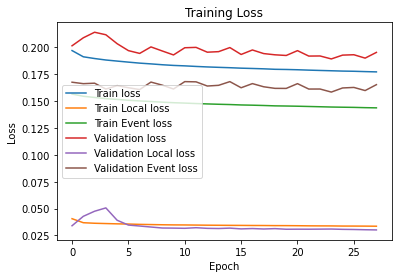

+ Train	 epoch: 29/30	 batch: 500/5366	 loss: 0.18392443656921387
+ Train	 epoch: 29/30	 batch: 1000/5366	 loss: 0.18524998426437378
+ Train	 epoch: 29/30	 batch: 1500/5366	 loss: 0.17387233674526215
+ Train	 epoch: 29/30	 batch: 2000/5366	 loss: 0.16223032772541046
+ Train	 epoch: 29/30	 batch: 2500/5366	 loss: 0.18885448575019836
+ Train	 epoch: 29/30	 batch: 3000/5366	 loss: 0.16773581504821777
+ Train	 epoch: 29/30	 batch: 3500/5366	 loss: 0.1668999195098877
+ Train	 epoch: 29/30	 batch: 4000/5366	 loss: 0.1579529345035553
+ Train	 epoch: 29/30	 batch: 4500/5366	 loss: 0.17432621121406555
+ Train	 epoch: 29/30	 batch: 5000/5366	 loss: 0.1912572681903839
Train	 epoch: 29/30	 loss: 0.17719329414841314
0.21081620454788208, 0.21081620454788208
0.1773166060447693, 0.1773166060447693
0.17905357480049133, 0.17905357480049133
0.18890094757080078, 0.18890094757080078
Validation	 epoch: 29/30	 loss: 0.18902183324098587
Saving model


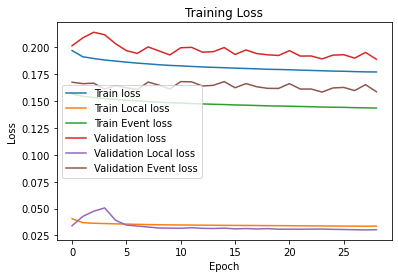

+ Train	 epoch: 30/30	 batch: 500/5366	 loss: 0.1651923805475235
+ Train	 epoch: 30/30	 batch: 1000/5366	 loss: 0.1787310540676117
+ Train	 epoch: 30/30	 batch: 1500/5366	 loss: 0.171404629945755
+ Train	 epoch: 30/30	 batch: 2000/5366	 loss: 0.1649777740240097
+ Train	 epoch: 30/30	 batch: 2500/5366	 loss: 0.18304751813411713
+ Train	 epoch: 30/30	 batch: 3000/5366	 loss: 0.18696600198745728
+ Train	 epoch: 30/30	 batch: 3500/5366	 loss: 0.17159028351306915
+ Train	 epoch: 30/30	 batch: 4000/5366	 loss: 0.17015302181243896
+ Train	 epoch: 30/30	 batch: 4500/5366	 loss: 0.16362124681472778
+ Train	 epoch: 30/30	 batch: 5000/5366	 loss: 0.16559679806232452
Train	 epoch: 30/30	 loss: 0.17693931889031922
0.22672149538993835, 0.22672149538993835
0.17982836067676544, 0.17982836067676544
0.18568335473537445, 0.18568335473537445
0.18336360156536102, 0.18336360156536102
Validation	 epoch: 30/30	 loss: 0.19389920309185982
Saving model


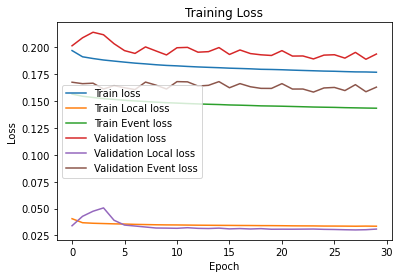

In [15]:
if ph2_saved:
  savePath = savePath_base+"TTNet_Phase2_1.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph2_train_loss_log = checkpoint['train_loss_log']
  ph2_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 2 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"Phase1_new_val/TTNet_Phase1_30.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  pretrained_dict = load_weights_local_stage(pretrained_dict)
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  start_epoch = 0
  print("Phase 2: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 2: Local + Event Stage ...')

for epoch in range(start_epoch+1, ph2_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0
  tr_loc_loss_total = 0
  tr_event_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()
    
    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

    # Model forward step
    with autocast():
      _, local_out, _, crop_params, event_out = model(window_batch)

    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (local+event) loss
    with autocast():
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = local_loss_train + event_loss_train
    
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    loc = local_loss_train.detach().cpu().numpy()
    event = event_loss_train.detach().cpu().numpy()
    
    train_loss_total += loss
    tr_loc_loss_total += loc
    tr_event_loss_total += event

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph2_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainimg losses
  print(f"Train\t epoch: {epoch}/{ph2_epochs}\t loss: {train_loss_total/batch_num}")
  ph2_train_loss_log.append(train_loss_total/batch_num)
  ph2_train_loc_log.append(tr_loc_loss_total/batch_num)
  ph2_train_event_log.append(tr_event_loss_total/batch_num)

  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    val_loc_loss_total = 0
    val_event_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # Model forward step
      with autocast():
        _, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (local+event) loss
      with autocast():
        local_loss_val = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_val = event_loss(event_out,event_probs) * event_weight
        val_loss = local_loss_val + event_loss_val

      loss = val_loss.detach().cpu().numpy()
      loc = local_loss_val.detach().cpu().numpy()
      event = event_loss_val.detach().cpu().numpy()
      print(f"{val_loss}, {event+loc}")


      val_loss_total += loss
      val_loc_loss_total += loc
      val_event_loss_total += event
      #val_loss_total += val_loss.item()

    ph2_val_loss_log.append(val_loss_total/batch_num)
    ph2_val_loc_log.append(val_loc_loss_total/batch_num)
    ph2_val_event_log.append(val_event_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph2_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"Phase2/TTNet_Phase2_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph2_train_loss_log,'val_loss_log':ph2_val_loss_log}
  torch.save(state, savePath) 
  ph2_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph2_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph2_train_loc_log,label='Train Local loss')
  plt.plot(range(epoch),ph2_train_event_log,label='Train Event loss')
  plt.plot(range(epoch),ph2_val_loss_log,label='Validation loss')
  plt.plot(range(epoch),ph2_val_loc_log,label='Validation Local loss')
  plt.plot(range(epoch),ph2_val_event_log,label='Validation Event loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph2.png")
  plt.show()

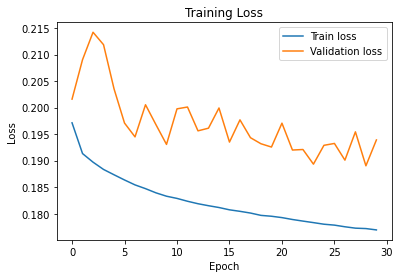

In [16]:
# Plot the losses
plt.clf()
plt.plot(range(epoch),ph2_train_loss_log,label='Train loss')
plt.plot(range(epoch),ph2_val_loss_log,label='Validation loss')
plt.legend()
#plt.xticks(range(epoch), range(1,31))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig(outputPath+"loss_ph2.png")
plt.show()

## Training Phase 3

In [15]:
# Training config
ph3_saved = False
ph3_epochs = 20
global_weight = 1
local_weight = 1
event_weight = 1
ph3_train_loss_log = []
ph3_val_loss_log = []

In [16]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Phase 3: No model to load, start to train at epoch 0
START TO TRAIN PHASE 3: All Stages ...
+ Train	 epoch: 1/20	 batch: 500/5366	 loss: 0.10483478009700775
+ Train	 epoch: 1/20	 batch: 1000/5366	 loss: 0.11699412763118744
+ Train	 epoch: 1/20	 batch: 1500/5366	 loss: 0.11246013641357422
+ Train	 epoch: 1/20	 batch: 2000/5366	 loss: 0.12438084185123444
+ Train	 epoch: 1/20	 batch: 2500/5366	 loss: 0.13822448253631592
+ Train	 epoch: 1/20	 batch: 3000/5366	 loss: 0.10660314559936523
+ Train	 epoch: 1/20	 batch: 3500/5366	 loss: 0.18654727935791016
+ Train	 epoch: 1/20	 batch: 4000/5366	 loss: 0.1513386368751526
+ Train	 epoch: 1/20	 batch: 4500/5366	 loss: 0.14585284888744354
+ Train	 epoch: 1/20	 batch: 5000/5366	 loss: 0.1464497148990631
Train	 epoch: 1/20	 loss: 0.12954715644351325
Validation	 epoch: 1/20	 loss: 0.16446265950798988
Saving model


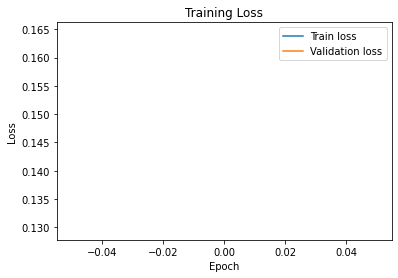

+ Train	 epoch: 2/20	 batch: 500/5366	 loss: 0.11927904933691025
+ Train	 epoch: 2/20	 batch: 1000/5366	 loss: 0.13580641150474548
+ Train	 epoch: 2/20	 batch: 1500/5366	 loss: 0.13348272442817688
+ Train	 epoch: 2/20	 batch: 2000/5366	 loss: 0.13451218605041504
+ Train	 epoch: 2/20	 batch: 2500/5366	 loss: 0.10616014152765274
+ Train	 epoch: 2/20	 batch: 3000/5366	 loss: 0.13808569312095642
+ Train	 epoch: 2/20	 batch: 3500/5366	 loss: 0.1175999715924263
+ Train	 epoch: 2/20	 batch: 4000/5366	 loss: 0.12873634696006775
+ Train	 epoch: 2/20	 batch: 4500/5366	 loss: 0.12717054784297943
+ Train	 epoch: 2/20	 batch: 5000/5366	 loss: 0.13371708989143372
Train	 epoch: 2/20	 loss: 0.12916088169784276
Validation	 epoch: 2/20	 loss: 0.15854763239622116
Saving model


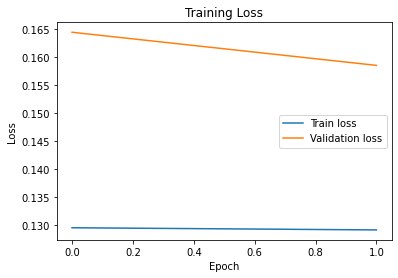

+ Train	 epoch: 3/20	 batch: 500/5366	 loss: 0.11607455462217331
+ Train	 epoch: 3/20	 batch: 1000/5366	 loss: 0.10847507417201996
+ Train	 epoch: 3/20	 batch: 1500/5366	 loss: 0.10921734571456909
+ Train	 epoch: 3/20	 batch: 2000/5366	 loss: 0.1101471334695816
+ Train	 epoch: 3/20	 batch: 2500/5366	 loss: 0.1258918046951294
+ Train	 epoch: 3/20	 batch: 3000/5366	 loss: 0.11754951626062393
+ Train	 epoch: 3/20	 batch: 3500/5366	 loss: 0.12753859162330627
+ Train	 epoch: 3/20	 batch: 4000/5366	 loss: 0.13908320665359497
+ Train	 epoch: 3/20	 batch: 4500/5366	 loss: 0.12189511954784393
+ Train	 epoch: 3/20	 batch: 5000/5366	 loss: 0.13314588367938995
Train	 epoch: 3/20	 loss: 0.12874035062521774
Validation	 epoch: 3/20	 loss: 0.1654820740222931
Saving model


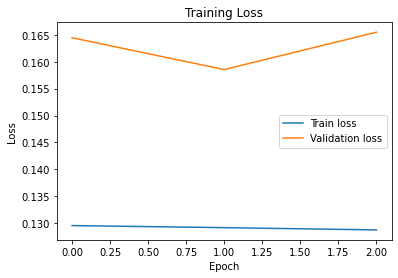

+ Train	 epoch: 4/20	 batch: 500/5366	 loss: 0.16309292614459991
+ Train	 epoch: 4/20	 batch: 1000/5366	 loss: 0.11901842057704926
+ Train	 epoch: 4/20	 batch: 1500/5366	 loss: 0.11168192327022552
+ Train	 epoch: 4/20	 batch: 2000/5366	 loss: 0.14460667967796326
+ Train	 epoch: 4/20	 batch: 2500/5366	 loss: 0.12421952188014984
+ Train	 epoch: 4/20	 batch: 3000/5366	 loss: 0.1160213053226471
+ Train	 epoch: 4/20	 batch: 3500/5366	 loss: 0.144741028547287
+ Train	 epoch: 4/20	 batch: 4000/5366	 loss: 0.13172173500061035
+ Train	 epoch: 4/20	 batch: 4500/5366	 loss: 0.11401952803134918
+ Train	 epoch: 4/20	 batch: 5000/5366	 loss: 0.1220838874578476
Train	 epoch: 4/20	 loss: 0.12814345444888264
Validation	 epoch: 4/20	 loss: 0.16448036581277847
Saving model


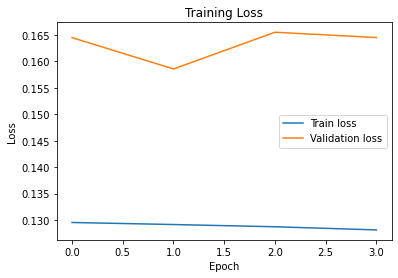

+ Train	 epoch: 5/20	 batch: 500/5366	 loss: 0.1511518359184265
+ Train	 epoch: 5/20	 batch: 1000/5366	 loss: 0.12857438623905182
+ Train	 epoch: 5/20	 batch: 1500/5366	 loss: 0.11732836067676544
+ Train	 epoch: 5/20	 batch: 2000/5366	 loss: 0.14173820614814758
+ Train	 epoch: 5/20	 batch: 2500/5366	 loss: 0.122813880443573
+ Train	 epoch: 5/20	 batch: 3000/5366	 loss: 0.15918755531311035
+ Train	 epoch: 5/20	 batch: 3500/5366	 loss: 0.11947990953922272
+ Train	 epoch: 5/20	 batch: 4000/5366	 loss: 0.14134778082370758
+ Train	 epoch: 5/20	 batch: 4500/5366	 loss: 0.11889860033988953
+ Train	 epoch: 5/20	 batch: 5000/5366	 loss: 0.11618129909038544
Train	 epoch: 5/20	 loss: 0.12744087919570643
Validation	 epoch: 5/20	 loss: 0.15833218023180962
Saving model


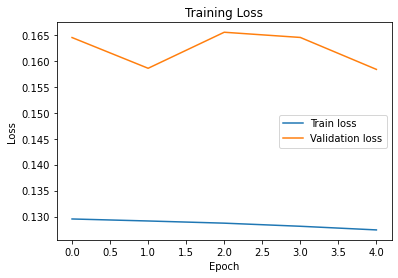

+ Train	 epoch: 6/20	 batch: 500/5366	 loss: 0.15570485591888428
+ Train	 epoch: 6/20	 batch: 1000/5366	 loss: 0.14558647572994232
+ Train	 epoch: 6/20	 batch: 1500/5366	 loss: 0.11004066467285156
+ Train	 epoch: 6/20	 batch: 2000/5366	 loss: 0.13021934032440186
+ Train	 epoch: 6/20	 batch: 2500/5366	 loss: 0.12795525789260864
+ Train	 epoch: 6/20	 batch: 3000/5366	 loss: 0.1417892873287201
+ Train	 epoch: 6/20	 batch: 3500/5366	 loss: 0.11907660961151123
+ Train	 epoch: 6/20	 batch: 4000/5366	 loss: 0.12262862920761108
+ Train	 epoch: 6/20	 batch: 4500/5366	 loss: 0.11405505985021591
+ Train	 epoch: 6/20	 batch: 5000/5366	 loss: 0.12332819402217865
Train	 epoch: 6/20	 loss: 0.1268420808344935
Validation	 epoch: 6/20	 loss: 0.1533719040453434
Saving model


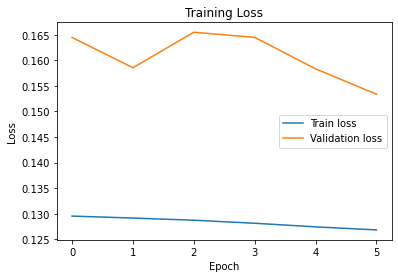

+ Train	 epoch: 7/20	 batch: 500/5366	 loss: 0.136646568775177
+ Train	 epoch: 7/20	 batch: 1000/5366	 loss: 0.12125551700592041
+ Train	 epoch: 7/20	 batch: 1500/5366	 loss: 0.1495210975408554
+ Train	 epoch: 7/20	 batch: 2000/5366	 loss: 0.10860057175159454
+ Train	 epoch: 7/20	 batch: 2500/5366	 loss: 0.1421041190624237
+ Train	 epoch: 7/20	 batch: 3000/5366	 loss: 0.09301930665969849
+ Train	 epoch: 7/20	 batch: 3500/5366	 loss: 0.11361269652843475
+ Train	 epoch: 7/20	 batch: 4000/5366	 loss: 0.13182789087295532
+ Train	 epoch: 7/20	 batch: 4500/5366	 loss: 0.12600040435791016
+ Train	 epoch: 7/20	 batch: 5000/5366	 loss: 0.13647088408470154
Train	 epoch: 7/20	 loss: 0.12639966963655327
Validation	 epoch: 7/20	 loss: 0.16147731244564056
Saving model


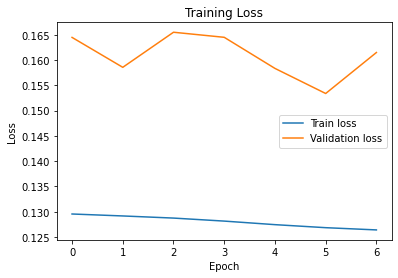

+ Train	 epoch: 8/20	 batch: 500/5366	 loss: 0.12328951060771942
+ Train	 epoch: 8/20	 batch: 1000/5366	 loss: 0.13652417063713074
+ Train	 epoch: 8/20	 batch: 1500/5366	 loss: 0.13311974704265594
+ Train	 epoch: 8/20	 batch: 2000/5366	 loss: 0.1236276924610138
+ Train	 epoch: 8/20	 batch: 2500/5366	 loss: 0.12071019411087036
+ Train	 epoch: 8/20	 batch: 3000/5366	 loss: 0.12695501744747162
+ Train	 epoch: 8/20	 batch: 3500/5366	 loss: 0.11196009814739227
+ Train	 epoch: 8/20	 batch: 4000/5366	 loss: 0.1640896499156952
+ Train	 epoch: 8/20	 batch: 4500/5366	 loss: 0.1357901394367218
+ Train	 epoch: 8/20	 batch: 5000/5366	 loss: 0.12170308828353882
Train	 epoch: 8/20	 loss: 0.12570776879104315
Validation	 epoch: 8/20	 loss: 0.16628294065594673
Saving model


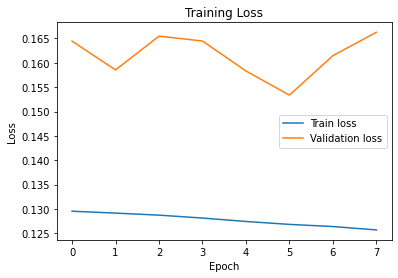

+ Train	 epoch: 9/20	 batch: 500/5366	 loss: 0.13268417119979858
+ Train	 epoch: 9/20	 batch: 1000/5366	 loss: 0.11378452926874161
+ Train	 epoch: 9/20	 batch: 1500/5366	 loss: 0.11433369666337967
+ Train	 epoch: 9/20	 batch: 2000/5366	 loss: 0.12619483470916748
+ Train	 epoch: 9/20	 batch: 2500/5366	 loss: 0.11516793072223663
+ Train	 epoch: 9/20	 batch: 3000/5366	 loss: 0.09101089090108871
+ Train	 epoch: 9/20	 batch: 3500/5366	 loss: 0.11069528758525848
+ Train	 epoch: 9/20	 batch: 4000/5366	 loss: 0.13921473920345306
+ Train	 epoch: 9/20	 batch: 4500/5366	 loss: 0.09101708233356476
+ Train	 epoch: 9/20	 batch: 5000/5366	 loss: 0.10607242584228516
Train	 epoch: 9/20	 loss: 0.1252740275613239
Validation	 epoch: 9/20	 loss: 0.1676359921693802
Saving model


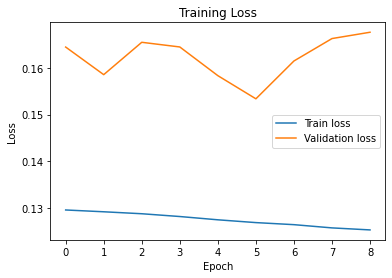

+ Train	 epoch: 10/20	 batch: 500/5366	 loss: 0.11336025595664978
+ Train	 epoch: 10/20	 batch: 1000/5366	 loss: 0.1035015732049942
+ Train	 epoch: 10/20	 batch: 1500/5366	 loss: 0.10323429107666016
+ Train	 epoch: 10/20	 batch: 2000/5366	 loss: 0.131818026304245
+ Train	 epoch: 10/20	 batch: 2500/5366	 loss: 0.13864964246749878
+ Train	 epoch: 10/20	 batch: 3000/5366	 loss: 0.10784772783517838
+ Train	 epoch: 10/20	 batch: 3500/5366	 loss: 0.1254086047410965
+ Train	 epoch: 10/20	 batch: 4000/5366	 loss: 0.1326543390750885
+ Train	 epoch: 10/20	 batch: 4500/5366	 loss: 0.11966510862112045
+ Train	 epoch: 10/20	 batch: 5000/5366	 loss: 0.13029548525810242
Train	 epoch: 10/20	 loss: 0.12493686520321308
Validation	 epoch: 10/20	 loss: 0.16931241005659103
Saving model


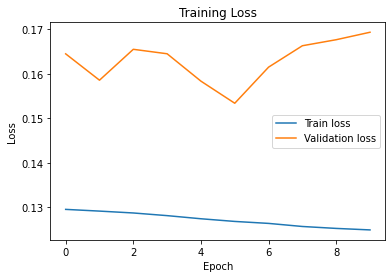

+ Train	 epoch: 11/20	 batch: 500/5366	 loss: 0.1569536030292511
+ Train	 epoch: 11/20	 batch: 1000/5366	 loss: 0.12452727556228638
+ Train	 epoch: 11/20	 batch: 1500/5366	 loss: 0.14854782819747925
+ Train	 epoch: 11/20	 batch: 2000/5366	 loss: 0.1420103907585144
+ Train	 epoch: 11/20	 batch: 2500/5366	 loss: 0.1482381820678711
+ Train	 epoch: 11/20	 batch: 3000/5366	 loss: 0.12630364298820496
+ Train	 epoch: 11/20	 batch: 3500/5366	 loss: 0.13331183791160583
+ Train	 epoch: 11/20	 batch: 4000/5366	 loss: 0.1326347291469574
+ Train	 epoch: 11/20	 batch: 4500/5366	 loss: 0.1383306384086609
+ Train	 epoch: 11/20	 batch: 5000/5366	 loss: 0.11087874323129654
Train	 epoch: 11/20	 loss: 0.12436662579772413
Validation	 epoch: 11/20	 loss: 0.1678282879292965
Saving model


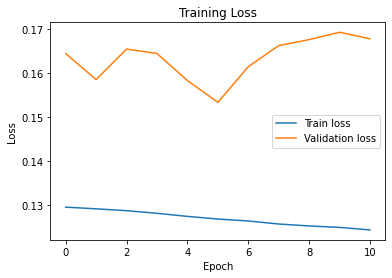

+ Train	 epoch: 12/20	 batch: 500/5366	 loss: 0.15625286102294922
+ Train	 epoch: 12/20	 batch: 1000/5366	 loss: 0.1415303349494934
+ Train	 epoch: 12/20	 batch: 1500/5366	 loss: 0.10376940667629242
+ Train	 epoch: 12/20	 batch: 2000/5366	 loss: 0.12857651710510254
+ Train	 epoch: 12/20	 batch: 2500/5366	 loss: 0.10635533928871155
+ Train	 epoch: 12/20	 batch: 3000/5366	 loss: 0.1225016862154007
+ Train	 epoch: 12/20	 batch: 3500/5366	 loss: 0.13542604446411133
+ Train	 epoch: 12/20	 batch: 4000/5366	 loss: 0.09232360124588013
+ Train	 epoch: 12/20	 batch: 4500/5366	 loss: 0.14620622992515564
+ Train	 epoch: 12/20	 batch: 5000/5366	 loss: 0.13775280117988586
Train	 epoch: 12/20	 loss: 0.12388251145223472
Validation	 epoch: 12/20	 loss: 0.17390206456184387
Saving model


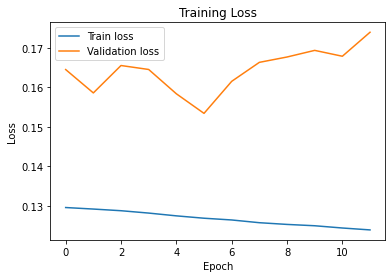

+ Train	 epoch: 13/20	 batch: 500/5366	 loss: 0.1170915886759758
+ Train	 epoch: 13/20	 batch: 1000/5366	 loss: 0.1584944725036621
+ Train	 epoch: 13/20	 batch: 1500/5366	 loss: 0.13901680707931519
+ Train	 epoch: 13/20	 batch: 2000/5366	 loss: 0.13790082931518555
+ Train	 epoch: 13/20	 batch: 2500/5366	 loss: 0.14015305042266846
+ Train	 epoch: 13/20	 batch: 3000/5366	 loss: 0.11348947137594223
+ Train	 epoch: 13/20	 batch: 3500/5366	 loss: 0.1197231113910675
+ Train	 epoch: 13/20	 batch: 4000/5366	 loss: 0.14005808532238007
+ Train	 epoch: 13/20	 batch: 4500/5366	 loss: 0.11761738359928131
+ Train	 epoch: 13/20	 batch: 5000/5366	 loss: 0.1376923769712448
Train	 epoch: 13/20	 loss: 0.12325481646820942
Validation	 epoch: 13/20	 loss: 0.1720336154103279
Saving model


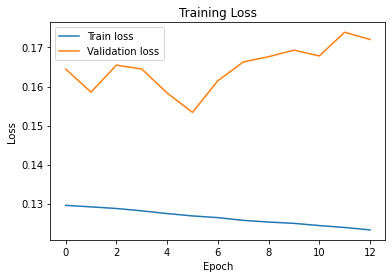

+ Train	 epoch: 14/20	 batch: 500/5366	 loss: 0.10477030277252197
+ Train	 epoch: 14/20	 batch: 1000/5366	 loss: 0.12623661756515503
+ Train	 epoch: 14/20	 batch: 1500/5366	 loss: 0.1373097151517868
+ Train	 epoch: 14/20	 batch: 2000/5366	 loss: 0.13014599680900574
+ Train	 epoch: 14/20	 batch: 2500/5366	 loss: 0.13403666019439697
+ Train	 epoch: 14/20	 batch: 3000/5366	 loss: 0.1295890212059021
+ Train	 epoch: 14/20	 batch: 3500/5366	 loss: 0.13370800018310547
+ Train	 epoch: 14/20	 batch: 4000/5366	 loss: 0.11026899516582489
+ Train	 epoch: 14/20	 batch: 4500/5366	 loss: 0.14748147130012512
+ Train	 epoch: 14/20	 batch: 5000/5366	 loss: 0.10542580485343933
Train	 epoch: 14/20	 loss: 0.12293410131675159
Validation	 epoch: 14/20	 loss: 0.16384262591600418
Saving model


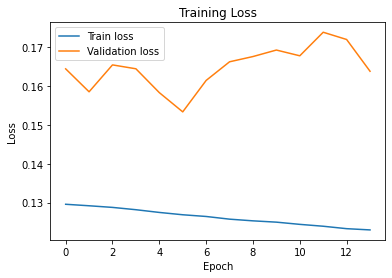

+ Train	 epoch: 15/20	 batch: 500/5366	 loss: 0.0978567972779274
+ Train	 epoch: 15/20	 batch: 1000/5366	 loss: 0.10305348038673401
+ Train	 epoch: 15/20	 batch: 1500/5366	 loss: 0.11127746850252151
+ Train	 epoch: 15/20	 batch: 2000/5366	 loss: 0.13672983646392822
+ Train	 epoch: 15/20	 batch: 2500/5366	 loss: 0.12486729770898819
+ Train	 epoch: 15/20	 batch: 3000/5366	 loss: 0.1054576113820076
+ Train	 epoch: 15/20	 batch: 3500/5366	 loss: 0.10523287951946259
+ Train	 epoch: 15/20	 batch: 4000/5366	 loss: 0.12023612856864929
+ Train	 epoch: 15/20	 batch: 4500/5366	 loss: 0.12497387826442719
+ Train	 epoch: 15/20	 batch: 5000/5366	 loss: 0.14246228337287903
Train	 epoch: 15/20	 loss: 0.12238946968590285
Validation	 epoch: 15/20	 loss: 0.16589536145329475
Saving model


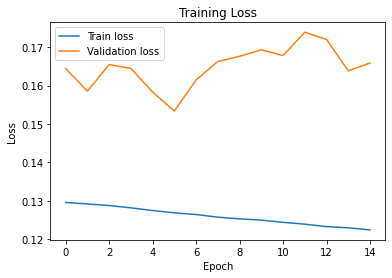

+ Train	 epoch: 16/20	 batch: 500/5366	 loss: 0.11361296474933624
+ Train	 epoch: 16/20	 batch: 1000/5366	 loss: 0.11641890555620193
+ Train	 epoch: 16/20	 batch: 1500/5366	 loss: 0.12017017602920532
+ Train	 epoch: 16/20	 batch: 2000/5366	 loss: 0.1360684186220169
+ Train	 epoch: 16/20	 batch: 2500/5366	 loss: 0.11795003712177277
+ Train	 epoch: 16/20	 batch: 3000/5366	 loss: 0.13282530009746552
+ Train	 epoch: 16/20	 batch: 3500/5366	 loss: 0.12412988394498825
+ Train	 epoch: 16/20	 batch: 4000/5366	 loss: 0.08999991416931152
+ Train	 epoch: 16/20	 batch: 4500/5366	 loss: 0.11402512341737747
+ Train	 epoch: 16/20	 batch: 5000/5366	 loss: 0.14207342267036438
Train	 epoch: 16/20	 loss: 0.12192026105304285
Validation	 epoch: 16/20	 loss: 0.17097441852092743
Saving model


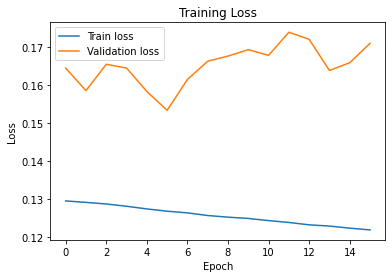

+ Train	 epoch: 17/20	 batch: 500/5366	 loss: 0.11527689546346664
+ Train	 epoch: 17/20	 batch: 1000/5366	 loss: 0.10360610485076904
+ Train	 epoch: 17/20	 batch: 1500/5366	 loss: 0.12917426228523254
+ Train	 epoch: 17/20	 batch: 2000/5366	 loss: 0.1380080282688141
+ Train	 epoch: 17/20	 batch: 2500/5366	 loss: 0.15408962965011597
+ Train	 epoch: 17/20	 batch: 3000/5366	 loss: 0.1184762492775917
+ Train	 epoch: 17/20	 batch: 3500/5366	 loss: 0.1403576135635376
+ Train	 epoch: 17/20	 batch: 4000/5366	 loss: 0.11456642299890518
+ Train	 epoch: 17/20	 batch: 4500/5366	 loss: 0.1277679055929184
+ Train	 epoch: 17/20	 batch: 5000/5366	 loss: 0.10800862312316895
Train	 epoch: 17/20	 loss: 0.1215251375835332
Validation	 epoch: 17/20	 loss: 0.1740328148007393
Saving model


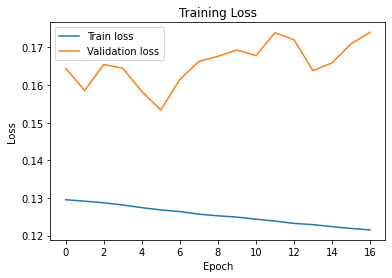

+ Train	 epoch: 18/20	 batch: 500/5366	 loss: 0.10764648020267487
+ Train	 epoch: 18/20	 batch: 1000/5366	 loss: 0.12636008858680725
+ Train	 epoch: 18/20	 batch: 1500/5366	 loss: 0.13123217225074768
+ Train	 epoch: 18/20	 batch: 2000/5366	 loss: 0.13118332624435425
+ Train	 epoch: 18/20	 batch: 2500/5366	 loss: 0.10087664425373077
+ Train	 epoch: 18/20	 batch: 3000/5366	 loss: 0.13695019483566284
+ Train	 epoch: 18/20	 batch: 3500/5366	 loss: 0.136785626411438
+ Train	 epoch: 18/20	 batch: 4000/5366	 loss: 0.11452516168355942
+ Train	 epoch: 18/20	 batch: 4500/5366	 loss: 0.12995128333568573
+ Train	 epoch: 18/20	 batch: 5000/5366	 loss: 0.11529848724603653
Train	 epoch: 18/20	 loss: 0.12095971126144074
Validation	 epoch: 18/20	 loss: 0.18153953179717064
Saving model


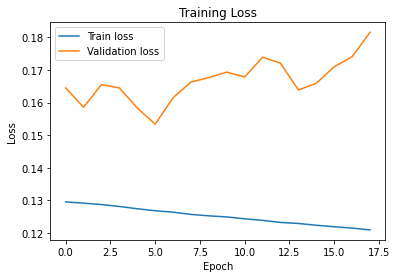

+ Train	 epoch: 19/20	 batch: 500/5366	 loss: 0.09847958385944366
+ Train	 epoch: 19/20	 batch: 1000/5366	 loss: 0.11412857472896576
+ Train	 epoch: 19/20	 batch: 1500/5366	 loss: 0.09806814789772034
+ Train	 epoch: 19/20	 batch: 2000/5366	 loss: 0.11122965812683105
+ Train	 epoch: 19/20	 batch: 2500/5366	 loss: 0.10990262031555176
+ Train	 epoch: 19/20	 batch: 3000/5366	 loss: 0.1224140077829361
+ Train	 epoch: 19/20	 batch: 3500/5366	 loss: 0.11931781470775604
+ Train	 epoch: 19/20	 batch: 4000/5366	 loss: 0.11152046918869019
+ Train	 epoch: 19/20	 batch: 4500/5366	 loss: 0.11842700093984604
+ Train	 epoch: 19/20	 batch: 5000/5366	 loss: 0.12603290379047394
Train	 epoch: 19/20	 loss: 0.12058562328855005
Validation	 epoch: 19/20	 loss: 0.17334461584687233
Saving model


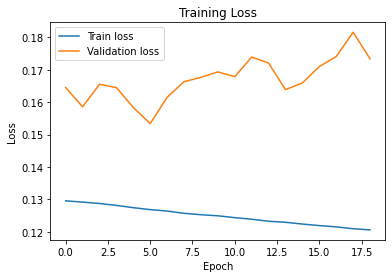

+ Train	 epoch: 20/20	 batch: 500/5366	 loss: 0.1326621025800705
+ Train	 epoch: 20/20	 batch: 1000/5366	 loss: 0.10701754689216614
+ Train	 epoch: 20/20	 batch: 1500/5366	 loss: 0.10240746289491653
+ Train	 epoch: 20/20	 batch: 2000/5366	 loss: 0.1183483749628067
+ Train	 epoch: 20/20	 batch: 2500/5366	 loss: 0.13007664680480957
+ Train	 epoch: 20/20	 batch: 3000/5366	 loss: 0.1180616170167923
+ Train	 epoch: 20/20	 batch: 3500/5366	 loss: 0.10716643929481506
+ Train	 epoch: 20/20	 batch: 4000/5366	 loss: 0.10307152569293976
+ Train	 epoch: 20/20	 batch: 4500/5366	 loss: 0.12877359986305237
+ Train	 epoch: 20/20	 batch: 5000/5366	 loss: 0.120096355676651
Train	 epoch: 20/20	 loss: 0.12033420415859679
Validation	 epoch: 20/20	 loss: 0.17752262949943542
Saving model


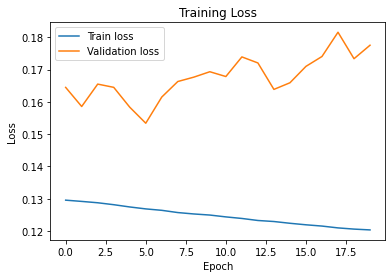

In [17]:
if ph3_saved:
  savePath = savePath_base+"TTNet_Phase3_4.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph3_train_loss_log = checkpoint['train_loss_log']
  ph3_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 3 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"Phase2_test/TTNet_Phase2_30.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  start_epoch = 0
  print("Phase 3: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 3: All Stages ...')

for epoch in range(start_epoch+1, ph3_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()

    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)
    
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

    # Model forward step
    with autocast():
      gloabl_out, local_out, _, crop_params, event_out = model(window_batch)
    
    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (global+local+event) loss
    with autocast():
      global_loss_train = ball_loss(gloabl_out,xy_downscale_batch) * global_weight
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = global_loss_train + local_loss_train + event_loss_train

    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    train_loss_total += loss

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph3_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")
    
    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainig losses
  print(f"Train\t epoch: {epoch}/{ph3_epochs}\t loss: {train_loss_total/batch_num}")
  ph3_train_loss_log.append(train_loss_total/batch_num)


  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

      # Model forward step
      with autocast():
        global_out, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (global+local+event) loss
      with autocast():
        global_loss_train = ball_loss(global_out,xy_downscale_batch) * global_weight
        local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_train = event_loss(event_out,event_probs) * event_weight
        val_loss = global_loss_train + local_loss_train + event_loss_train
      
      loss = val_loss.detach().cpu().numpy()
      val_loss_total += loss

    ph3_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph3_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"TTNet_Phase3_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph3_train_loss_log,'val_loss_log':ph3_val_loss_log}
  torch.save(state, savePath) 
  ph3_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph3_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph3_val_loss_log,label='Validation loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph3.png")
  plt.show()

## Testing

In [13]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
savePath = savePath_base+"Final/TTNet.pth"
checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['model']) 

<All keys matched successfully>

In [49]:
transform = transforms.Compose([
  transforms.Resize((TTN_height,TTN_width)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class demo_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = sorted(glob.glob('./tmp/*.jpg'))
    self.window_paths = []

    for frame_no, _ in enumerate(self.img_paths):
      if not (window_size-2 < frame_no <= len(self.img_paths)-1):
        continue

      # Get frame window image paths
      window_path = []
      middle_index = frame_no-self.window_size+(self.window_size+1)//2
      for window_frame in range(self.window_size):
        window_path.append(self.img_paths[(frame_no+1)-self.window_size+window_frame])
      self.window_paths.append(window_path)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)

    return window_imgs, window_path[self.window_size//2]

  def __len__(self):
    return len(self.window_paths)

def preprocess(video_path):
  cap = cv.VideoCapture(video_path)
  ret, frame = cap.read()
  count=0
  while(ret):
    cv.imwrite(f"tmp/{count:04d}.jpg", frame)
    ret, frame = cap.read()
    count += 1
    if count %200 == 0:
      print(f"Frame {count}")
  cap.release

def predict(video_path, preprocessing=True):
  if preprocessing:
    print("Preprocessing")
    preprocess(video_path)
  print("Loading demo dataset")
  demo_dataset  = demo_data_loader()
  demo_loader = DataLoader(demo_dataset, batch_size=8,shuffle=False,num_workers=num_workers,pin_memory=True,drop_last=True)

  cap = cv.VideoCapture(video_path)
  fps = cap.get(cv.CAP_PROP_FPS)
  cap.release
  fourcc = cv.VideoWriter_fourcc(*'mp4v')
  out = cv.VideoWriter('./Results/TTNet_Results/videos/out.mp4', fourcc, fps, (1920,1080))

  print("Making Predictions")
  model.eval()
  with torch.no_grad():
    events = ["Out of image", "Flying", "Bounce", "Hit", "Net Contact"]

    for i,data_batch in enumerate(tqdm(demo_loader)):
      # Read in demo batch
      window_imgs, window_centre = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)
      # Model forward step
      global_out, local_out, local_in, crop_params, event_out = model(window_batch)

      local_out_clone = local_out.clone().detach()
      global_out_clone = global_out.clone().detach()
      event_out_clone = event_out.clone().detach()

      for out_index in range(local_out_clone.shape[0]):
        # Global bounding box
        _, x_min, y_min, x_max, y_max, _, _ = crop_params[out_index]

        # Ball prediction
        local_x = torch.argmax(local_out_clone[out_index,:TTN_width]).item()
        local_y = torch.argmax(local_out_clone[out_index,TTN_width:]).item()
        global_x = torch.argmax(global_out_clone[out_index,:TTN_width]).item()
        global_y = torch.argmax(global_out_clone[out_index,TTN_width:]).item()

        x_pred = global_x*data_width/TTN_width-TTN_width/2+local_x
        y_pred = global_y*data_height/TTN_height-TTN_height/2+local_y
        x_pred = 0 if x_pred<0 else int(x_pred)
        y_pred = 0 if y_pred<0 else int(y_pred)

        # Event prediction
        event_preds = event_out_clone[out_index]

        # Label frame
        centre_img = cv.imread(window_centre[out_index])
        cv.rectangle(centre_img, (x_min,y_min), (x_max,y_max), (0,0,255), 2)
        cv.circle(centre_img,(x_pred,y_pred), 8,  (0, 0, 255), 2)
        #cv.putText(centre_img, event_text, (50, 250), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)
        event_text = f"Event: Not in image {event_preds[0].item()}"
        cv.putText(centre_img, event_text, (50, 100), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)
        event_text = f"Event: Flying {event_preds[1].item()}"
        cv.putText(centre_img, event_text, (50, 150), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        event_text = f"Event: Bouncing {event_preds[2].item()}"
        cv.putText(centre_img, event_text, (50, 200), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        event_text = f"Event: Hit {event_preds[3].item()}"
        cv.putText(centre_img, event_text, (50, 250), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2)
        event_text = f"Event: Net Contact {event_preds[4].item()}"
        cv.putText(centre_img, event_text, (50, 300), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)

        out.write(centre_img)
  out.release()


predict("./Results/TTNet_Results/videos/test.mp4", False)

Loading demo dataset
Making Predictions


  0%|          | 0/224 [00:00<?, ?it/s]